In [2]:
import numpy as np
import scipy.stats as stats

In [3]:
def TSVtoList(tsvFile):
    import csv
    #Create a container for the tsv
    tsvList = []
    #Open the .tsv file and append it to a python list
    with open(tsvFile,'rb') as tsvIn:
        tsvIn = csv.reader(tsvIn, delimiter='\t')
        for row in tsvIn:
            tsvList.append(row)
    return tsvList

In [4]:
def ExcludeNonImageRows(tsvList):
    index = []
    currentIndex = 1
    mediaNameIndex = GetIndexForHeader("MediaName")
    for row in tsvList[1:]:
        if row[mediaNameIndex] == "":
            index.append(currentIndex)
        currentIndex += 1
    for row in reversed(index):
        del tsvList[row]
    return tsvList[1:]

In [5]:
def ExcludeNonAOIRows(tsvList):
    saveRow = False
    returnList = []
    for row in tsvList:
        #print row[GetIndexForHeader("FixationIndex")], row[GetIndexForHeader("SaccadeIndex")]
        FixationIndexIndex = GetIndexForHeader("FixationIndex")
        AOIHeader = GetIndexForHeader("AOI[AOI]Hit")
        questionNumber = row[GetIndexForHeader("MediaName")]
        aORb = questionNumber[2]
        questionNumber = int(questionNumber[-6:-4])
        if aORb == "A":
            AOIHeader = AOIHeader + (2*(questionNumber-1))
        elif aORb == "B":
            AOIHeader = AOIHeader + (24*2) +(2*(questionNumber-1))
            
        if row[AOIHeader] == "1":
            saveRow = True
        if row[FixationIndexIndex] != "" and row[AOIHeader] == "0":
            saveRow = False
            
        if saveRow is True:
            returnList.append(row) 
    return returnList

In [6]:
def DivideIntoSeparateImageLists(tsvList):
    imageDictionary = {}
    mediaNameIndex = GetIndexForHeader("MediaName")
    for row in tsvList[1:]:
        if row[113] not in imageDictionary:
            imageDictionary[row[mediaNameIndex]] = [row]
        else:
            imageDictionary[row[mediaNameIndex]].append(row)
    return imageDictionary

In [7]:
def CalculateDurationForImage(dataList):
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    start =  float(dataList[0][RecordingTimestampIndex])
    end = float(dataList[-1][RecordingTimestampIndex])
    duration = end - start
    #Convert to seconds
    duration = duration
    return duration

In [8]:
def CalculateFixation(dataList):
    fixations = {}
    fixationIndex = GetIndexForHeader("FixationIndex")
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    for row in dataList:
        if row[fixationIndex] not in fixations.keys():
            fixations[row[fixationIndex]] = []
            fixations[row[fixationIndex]].append(row)
        elif row[fixationIndex] in fixations.keys():
            fixations[row[fixationIndex]].append(row)
    fixations.pop('', None)
    fixationCount = len(fixations.keys())
    fixationDuration = []
    for key in fixations.keys():
        start = fixations[key][0][RecordingTimestampIndex]
        end = fixations[key][-1][RecordingTimestampIndex]
        duration = int(end) - int(start)
        fixationDuration.append(duration)
    fixationDuration = [x for x in fixationDuration if x != 0]
    fixationDurationAverage = np.mean(fixationDuration)
    fixationDurationTotal = np.sum(fixationDuration)
    return fixationCount, fixationDurationAverage, fixationDurationTotal

In [9]:
def CalculateSaccade(dataList):
    saccades = {}
    amplitudes = {}
    saccadicAmplitudeIndex = GetIndexForHeader("SaccadicAmplitude")
    saccadeIndex = GetIndexForHeader("SaccadeIndex")
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    prev = "x"
    curr = "x"
    for i in xrange(len(dataList)):
        if dataList[i][saccadeIndex] != "":
            curr = dataList[i][saccadeIndex]
        amplitudes[curr] = dataList[i][saccadicAmplitudeIndex]
        if dataList[i][saccadeIndex] not in saccades.keys():
            saccades[dataList[i][saccadeIndex]] = []
            saccades[dataList[i][saccadeIndex]].append(dataList[i])
        elif dataList[i][saccadeIndex] in saccades.keys():
            saccades[dataList[i][saccadeIndex]].append(dataList[i])
        prev = curr
        curr = dataList[i][saccadeIndex]
        if curr == "":
            if prev in saccades.keys():
                amplitudes[prev] = dataList[i][saccadicAmplitudeIndex]
    saccades.pop('', None)
    amplitudes.pop('', None)
    amplitudes.pop('x', None)
    saccadeDuration = []
    saccadeAmp = []
    saccadeVel = []
    for key in saccades.keys():
        start = saccades[key][0][RecordingTimestampIndex]
        end = saccades[key][-1][RecordingTimestampIndex]
        duration = int(end) - int(start)
        if amplitudes[key] != "" and duration != 0:
            saccadeDuration.append(duration)
            sacAmp = amplitudes[key]
            sacAmp = sacAmp.replace(',','.')
            sacAmp = float(sacAmp)
            saccadeAmp.append(sacAmp)
            saccadeVel.append(sacAmp/float(duration))
    return saccadeDuration, saccadeAmp, saccadeVel

In [10]:
def test(dataList):
    for i in range(0,200):
        print dataList[i][GetIndexForHeader("SaccadeIndex")], dataList[i][GetIndexForHeader("SaccadicAmplitude")]

In [11]:
def CalculateAmountOfFixations(dataList):
    #index = 0
    FixationIndexIndex = GetIndexForHeader("FixationIndex")
    #for row in dataList:
        #if dataList[index][FixationIndexIndex] is not "":
            #break
        #index += 1
    #start = int(dataList[index][FixationIndexIndex])
    #index = -1
    #for row in reversed(dataList):
        #if dataList[index][FixationIndexIndex] is not "":
            #break
        #index -= 1
    #end = int(dataList[index][FixationIndexIndex])
    #amount = end - start
    
    amountList = []
    
    for row in dataList:
        if row[FixationIndexIndex] not in amountList:
            amountList.append(row[FixationIndexIndex])
    amount = len(amountList)
    return amount

In [12]:
def CalculateFixationPrecision(dataList):
    notedFixations = []
    count = 0
    FixationIndexIndex = GetIndexForHeader("FixationIndex")
    AOIHeader = GetIndexForHeader("AOI[Polygon]Hit")
    questionNumber = dataList[1][GetIndexForHeader("MediaName")]
    aORb = questionNumber[2]
    questionNumber = int(questionNumber[-6:-4])
    if aORb == "A":
        AOIHeader = AOIHeader + (2*(questionNumber-1))
    elif aORb == "B":
        AOIHeader = AOIHeader + (24*2) +(2*(questionNumber-1))
    for row in dataList:
        if row[AOIHeader] == "1":
            if row[FixationIndexIndex] not in notedFixations:
                notedFixations.append(row[FixationIndexIndex])
                count += 1
    return count

In [13]:
def CalculateFixationDuration(dataList):
    index = 0
    FixationIndexIndex = GetIndexForHeader("FixationIndex")
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    prev = "0"
    current = "0"
    start = 0
    end = 0
    fixationDurations = []
    for row in dataList:
        prev = current
        current = row[FixationIndexIndex]
        #print row[FixationIndexIndex], row[GetIndexForHeader("SaccadeIndex")]
        if prev is "" and current is not "":
            start = row[RecordingTimestampIndex]
        elif prev is not "" and current is "":
            end = row[RecordingTimestampIndex]
            duration = int(end) - int(start)
            duration = float(duration)
            fixationDurations.append(duration)
    return fixationDurations

In [14]:
def CalculateAmountOfFixationsPerSecond(duration, amountOfFixations):
    duration = float(duration)
    amountOfFixations = float(amountOfFixations)
    fixationsPerSecond = amountOfFixations/duration
    return fixationsPerSecond

In [15]:
def CalculateAmountOfSaccades(dataList):
    #saccadeList = []
    SaccadeIndexIndex = GetIndexForHeader("SaccadeIndex")
    #for row in dataList:
        #if row[145] is not "":
            #saccadeList.append(row[SaccadeIndexIndex])
    #start = int(min(saccadeList))
    #end = int(max(saccadeList))
    #amountOfSaccades = end - start
    
    amountList = []
    
    for row in dataList:
        if row[SaccadeIndexIndex] not in amountList:
            amountList.append(row[SaccadeIndexIndex])
    
    amountOfSaccades = len(amountList)
    
    return amountOfSaccades

In [16]:
def CalculateDurationOfSaccades(dataList):
    saccadeDurationList = []
    tempSaccadeDurationList = []
    RecordingTimestampIndex = GetIndexForHeader("RecordingTimestamp")
    SaccadeIndexIndex = GetIndexForHeader("SaccadeIndex")
    for row in dataList:
        if row[SaccadeIndexIndex] is not "":
            tempSaccadeDurationList.append(int(row[RecordingTimestampIndex]))
        else:
            if len(tempSaccadeDurationList) is not 0:
                saccadeStart = tempSaccadeDurationList[0]
                saccadeEnd = tempSaccadeDurationList[-1]
                saccadeDuration = saccadeEnd - saccadeStart
                saccadeDurationList.append(saccadeDuration)
                tempSaccadeDurationList = []
    if len(tempSaccadeDurationList) is not 0:
        sacadeStart = tempSaccadeDurationList[0]
        saccadeEnd = tempSaccadeDurationList[-1]
        saccadeDuration = saccadeEnd - saccadeStart
        saccadeDurationList.append(saccadeDuration)
        
    return saccadeDurationList

In [17]:
def CalculateVelocityOfSaccades(dataList):
    listOfVelocities = []
    startIndex = 0
    SaccadicAmplitudeIndex = GetIndexForHeader("SaccadicAmplitude")
    if dataList[0][SaccadicAmplitudeIndex] is not "":
        for row in dataList:
            if row[SaccadicAmplitudeIndex] is "":
                break
            else:
                startIndex += 1
    previous = ""
    current = ""
    for row in dataList[startIndex:]:
        previous = current
        current = row[SaccadicAmplitudeIndex]
        if previous is "" and current is not "":
            #convert number because it uses comma and needs to use punctuation
            number = float(row[SaccadicAmplitudeIndex].replace(',','.'))
            listOfVelocities.append(number)
    return listOfVelocities

In [18]:
def CalculatePupilDilation(dataList):
    pupilLeft = []
    pupilRight = []
    PupilLeftIndex = GetIndexForHeader("PupilLeft")
    for row in dataList:
        #print row
        print row[PupilLeftIndex]
        pupilLeft.append(float(row[PupilLeftIndex].replace(',','.')))
        pupilRight.append(float(row[PupilLeftIndex + 1].replace(',','.')))
    return pupilLeft, pupilRight

In [19]:
def GetIndexForHeader(name):
    indexForHeader = dataHeaders.index(name)
    return indexForHeader

In [20]:
def CalculateAccuracy(dataList):
    print dataList[0]

In [23]:
filePath = "C:/Users/Simon/Documents/Skole/Master/participants/processed/p764b@pupil@study_data_processed.tsv"

dataList = TSVtoList(filePath)

dataHeaders = dataList[0]

dataList = ExcludeNonImageRows(dataList)

dataDictionary = DivideIntoSeparateImageLists(dataList)

print(dataDictionary.keys())

IOError: [Errno 2] No such file or directory: 'C:/Users/Simon/Documents/Skole/Master/participants/processed/p764b@pupil@study_data_processed.tsv'

In [ ]:
index = 0
for header in dataHeaders:
    print str(index) + ": " + header
    index += 1 

In [20]:
duration = CalculateDurationForImage(dataDictionary["M4A-Q24.png"])
print duration

NameError: name 'dataDictionary' is not defined

In [21]:
amountOfFixations = CalculateAmountOfFixations(dataDictionary["M4A-Q24.png"])
print amountOfFixations

NameError: name 'dataDictionary' is not defined

In [22]:
fixationDuration = CalculateFixationDuration(dataDictionary["M4A-Q24.png"])
print np.mean(fixationDuration)

NameError: name 'dataDictionary' is not defined

In [23]:
fixationsPerSecond = CalculateAmountOfFixationsPerSecond(duration, amountOfFixations)
print fixationsPerSecond

NameError: name 'duration' is not defined

In [24]:
amountOfSaccades = CalculateAmountOfSaccades(dataDictionary["M4A-Q24.png"])
print amountOfSaccades

NameError: name 'dataDictionary' is not defined

In [25]:
saccadeDurationList = CalculateDurationOfSaccades(dataDictionary["M4A-Q24.png"])
print np.mean(saccadeDurationList)

NameError: name 'dataDictionary' is not defined

In [26]:
strTest = "M1A-Q01.png"
print strTest[-6:-4]

01


In [27]:
saccadeVelocityList = CalculateVelocityOfSaccades(dataDictionary["M4A-Q24.png"])
print np.mean(saccadeVelocityList)

NameError: name 'dataDictionary' is not defined

In [28]:
import numpy as np
pupilDilationLeftList, pupilDilationRightList = CalculatePupilDilation(dataDictionary["M4A-Q24.png"])
print np.mean(pupilDilationLeftList), np.var(pupilDilationLeftList), np.std(pupilDilationLeftList)
print np.mean(pupilDilationRightList), np.var(pupilDilationRightList), np.std(pupilDilationRightList)

NameError: name 'dataDictionary' is not defined

In [358]:
import os

#Variables to hold the data
data = {}
dataHeaders = []

filePath = "C:/Users/Simon/Documents/Skole/Master/participants/processed/"
filePath = "C:/Users/Simon/Downloads/xxx/"

#filePath = "/Users/SMC/Documents/Skole/MasterThesis/finaltest/"

#fileList = os.listdir(filePath)
#fileList = fileList[1:]

for participant in os.listdir(filePath):
    #participantshort = participant[:5]
    
    newPath = filePath + participant
    
    dataList = TSVtoList(newPath)

    dataHeaders = dataList[0]
    
    participantshort = dataList[1][GetIndexForHeader("ParticipantName")]
    print participantshort, participant

    dataListExcluded = ExcludeNonImageRows(dataList)
    print len(dataListExcluded)
    dataListExcluded = ExcludeNonAOIRows(dataListExcluded)
    print len(dataListExcluded)
    dataList = dataList[1:]

    dataDictionary = DivideIntoSeparateImageLists(dataListExcluded)
    
    aORb = participantshort[-1]
    dataList = dataList[-1]
    
    answerKey = {"M1X-Q01":"True",
                "M1X-Q02":"True",
                "M1X-Q03":"True",
                "M1X-Q04":"False",
                "M1X-Q05":"False",
                "M1X-Q06":"False",
                "M2X-Q07":"False",
                "M2X-Q08":"True",
                "M2X-Q09":"True",
                "M2X-Q10":"False",
                "M2X-Q11":"False",
                "M2X-Q12":"False",
                "M3X-Q13":"True",
                "M3X-Q14":"False",
                "M3X-Q15":"True",
                "M3X-Q16":"False",
                "M3X-Q17":"True",
                "M3X-Q18":"False",
                "M4X-Q19":"True",
                "M4X-Q20":"False",
                "M4X-Q21":"True",
                "M4X-Q22":"False",
                "M4X-Q23":"True",
                "M4X-Q24":"False"}
    
    for image in dataDictionary:
        if image not in data:
            data[image] = {}
            data[image]["duration"] = []
            data[image]["accuracy"] = []
            data[image]["amountOfFixations"] = []
            data[image]["fixationDuration"] = []
            data[image]["fixationDurationTotal"] = []
            data[image]["fixationsPerSecond"] = []
            data[image]["amountOfSaccades"] = []
            data[image]["saccadeDurationList"] = []
            data[image]["saccadeVelocityList"] = []
            data[image]["pupilDilationLeftList"] = []
            data[image]["pupilDilationRightList"] = []
            data[image]["pupilDilationMean"] = []
            data[image]["fixationPrecision"] = []
            data[image]["saccadeDur"] = []
            data[image]["saccadeAmp"] = []
            data[image]["saccadeVel"] = []
        duration = CalculateDurationForImage(dataDictionary[image])
        data[image]["duration"].append(duration)
        amountOfFixations = CalculateAmountOfFixations(dataDictionary[image])
        #data[image]["amountOfFixations"].append(amountOfFixations)
        fixationDuration = CalculateFixationDuration(dataDictionary[image])
        #data[image]["fixationDuration"].append(np.mean(fixationDuration))
        #data[image]["fixationDurationTotal"].append(np.sum(fixationDuration))
        #fixationsPerSecond = CalculateAmountOfFixationsPerSecond(duration, amountOfFixations)
        #data[image]["fixationsPerSecond"].append(fixationsPerSecond)
        #amountOfSaccades = CalculateAmountOfSaccades(dataDictionary[image])
        #data[image]["amountOfSaccades"].append(amountOfSaccades)
        #saccadeDurationList = CalculateDurationOfSaccades(dataDictionary[image])
        #data[image]["saccadeDurationList"].append(saccadeDurationList)
        #saccadeVelocityList = CalculateVelocityOfSaccades(dataDictionary[image])
        #data[image]["saccadeVelocityList"].append(saccadeVelocityList)
        #pupilDilationLeftList, pupilDilationRightList = CalculatePupilDilation(dataDictionary[image])
        #data[image]["pupilDilationLeftList"].append(np.std(pupilDilationLeftList))
        #data[image]["pupilDilationRightList"].append(np.std(pupilDilationRightList))
        #data[image]["pupilDilationMean"].append(np.mean([np.std(pupilDilationLeftList),np.std(pupilDilationRightList)]))
        #fixationPrecision = CalculateFixationPrecision(dataDictionary[image])
        saccadeDur,  saccadeAmp, saccadeVel = CalculateSaccade(dataDictionary[image])
        data[image]["saccadeDur"].append(saccadeDur)
        data[image]["saccadeAmp"].append(saccadeAmp)
        data[image]["saccadeVel"].append(np.mean(saccadeVel))
        #print fixationPrecision, amountOfFixations, image
        fixationCount, fixationDurationAverage, fixationDurationTotal = CalculateFixation(dataDictionary[image])
        data[image]["amountOfFixations"].append(fixationCount)
        data[image]["fixationDuration"].append(fixationDurationAverage)
        data[image]["fixationDurationTotal"].append(fixationDurationTotal)
        try:
            fixationPrecision = float(fixationPrecision) / float(amountOfFixations) * 100
            data[image]["fixationPrecision"].append(fixationPrecision)
        except:
            print "Devision by zero"
        
        imageShort = image[:-4]
        if imageShort[0] != "T":
            answer = dataList[GetIndexForHeader("["+imageShort+"]Value")]
            if answer[0] == " ":
                answer = answer[1:]
            pre = imageShort[:2]
            post = imageShort[-4:]
            if answerKey[pre+"X"+post] == answer:
                data[image]["accuracy"].append(1)
            else:
                data[image]["accuracy"].append(0)


p024a p024a.tsv
189448
117773
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
p057a p057a.tsv
235470
150788
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
p335b p335b.tsv
150095
104375
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision by zero
Devision 

In [94]:
for key in data.keys():
    for row in data[key]["saccadeDurAmp"]:
        for comb in row:
            comb[1] = comb[1].replace(',','.')
            comb[1] = float(comb[1])

In [22]:
print data["M1A-Q01.png"]["saccadeDurAmp"]

KeyError: 'saccadeDurAmp'

In [23]:
measure = "amountOfFixations"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]
print data["M4A-Q23.png"][measure]
print M2A
print sorted(M2A)[-1]

[58, 41, 80, 90, 214, 49, 161]
[47, 76, 55, 37, 96, 50, 92, 36, 57, 73, 51, 69, 55, 41, 46, 68, 40, 42, 59, 57, 66, 55, 105, 93, 41, 142, 104, 124, 45, 41, 105, 66, 116, 63, 103, 32, 91, 105, 77, 69, 241, 128]
241


In [211]:
measure = "fixationDurationTotal"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]
print M4A[-10]
print sorted(M4A)[-1]

53782
53782


In [212]:
measure = "saccadeVelocityList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]
print M4A[-10]
print sorted(M4A)[-1]

IndexError: list index out of range

In [213]:
print data["M1B-Q01.png"]["fixationDurationTotal"]
print data["M1B-Q01.png"]["duration"]
print data["M1B-Q01.png"]["amountOfFixations"]
print data["M1B-Q01.png"]["fixationDuration"]

[5313, 22818, 21701, 14214, 38536, 8987]
[9359.0, 30832.0, 27132.0, 18014.0, 54807.0, 12625.0]
[36, 82, 78, 54, 169, 31]
[147.58333333333334, 278.26829268292681, 278.21794871794873, 263.22222222222223, 228.02366863905326, 289.90322580645159]


In [214]:
48*146.14583333333334

7015.0

In [215]:
print data["M1B-Q01.png"].keys()

['fixationDuration', 'fixationPrecision', 'saccadeVelocityList', 'accuracy', 'saccadeDur', 'fixationsPerSecond', 'saccadeVel', 'pupilDilationLeftList', 'amountOfSaccades', 'saccadeAmp', 'duration', 'pupilDilationMean', 'fixationDurationTotal', 'saccadeDurationList', 'pupilDilationRightList', 'amountOfFixations']


In [216]:
index = 0
for row in dataHeaders:
    print index, row, dataDictionary["M1B-Q01.png"][1][index]
    index += 1

0 ﻿ExportDate

KeyError: 'M1B-Q01.png'

In [217]:
GetIndexForHeader("AOI[AOI]Hit")

153

In [218]:
for row in dataDictionary["M1A-Q01.png"]:
    print row[GetIndexForHeader("FixationIndex")], row[GetIndexForHeader("SaccadeIndex")], row[GetIndexForHeader("AOI[AOI]Hit")]

207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
207  1
 230 0
 230 0
 230 0
 230 0
 230 0
 230 0
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
208  1
 231 0
 231 0
 231 0
 231 0
 231 0
 231 0
 231 0
 231 0
 231 0
 231 0
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1
209  1

236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
236  1
 259 0
 259 0
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
237  1
 260 0
 260 0
 260 0
 260 0
 260 0
 260 0
 260 0
 260 0
 260 0
 260 0
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
238  1
 261 0
 261 0
 261 0
 261 0
 261 0

260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
260  1
 285 0
 285 0
 285 0
 285 0
 285 0
 285 0
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1
261  1

276  1
 304 0
 304 0
 304 0
 304 0
 304 0
 304 0
 304 0
 304 0
 304 0
 304 0
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
277  1
 305 0
 305 0
 305 0
 305 0
 305 0
 305 0
 305 0
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1
278  1

In [219]:
measure = "pupilDilationMean"
TUT = data["TUTX-Q01.png"][measure] + data["TUTX-Q02.png"][measure] + data["TUTX-Q03.png"][measure]
tutMean = np.mean(TUT)

for image in data.keys():
    data[image]["pupilDilationDiff"] = []
    for index in xrange(len(data[image]["pupilDilationMean"])):
        data[image]["pupilDilationDiff"].append(float(data[image]["pupilDilationMean"][index])-float(TUT[index]))

KeyError: 'TUTX-Q01.png'

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
print data['M2B-Q11.png']["fixationPrecision"]

In [ ]:
def getModelData(model, measure, localAndGlobal="Both"):
    multiplier = int(model[1])
    aORb = model[2]
    end = 6 * multiplier
    start = end - 5
    if localAndGlobal is "Local":
        end = end - 3
    elif localAndGlobal is "Global":
        start = start + 3
    prefix = model +"-"
    questions = []
    for index in range(start, end+1):
        question = index
        question = "%02d" % (question,)
        question = "Q"+question
        questions.append(question)
    
    collecter = []
    for question in questions:
        collecter += data[prefix+question+".png"][measure]
    
    return collecter

print getModelData("M1A", "duration")
%matplotlib inline

In [ ]:
%matplotlib inline
measure = "duration"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]





def boxplot(figureSubtitle, ylabel, MA, MB):
    fig = plt.figure(figsize=(9,6))
    #fig.suptitle(figureSubtitle, fontsize=14, fontweight='bold')

    ax1A = fig.add_subplot(121)
    ax1A.set_ylabel(ylabel)
    ax1A.set_xlabel("Group A")
    ax1A.tick_params(axis="x", which="both", bottom="off", top="off", labelbottom="off")
    bp1A = ax1A.boxplot(MA)

    ax1B = fig.add_subplot(122, sharey = ax1A)
    ax1B.set_ylabel(ylabel)
    ax1B.set_xlabel("Group B")
    ax1B.tick_params(axis="x", which="both", bottom="off", top="off", labelbottom="off")
    bp1B = ax1B.boxplot(MB)
    
    return fig
db = "DurationBoxplot"    
m1 = boxplot("Model 1 duration", "Time (sec)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 duration", "Time (sec)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 duration", "Time (sec)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 duration", "Time (sec)", M4A, M4B)
m4.savefig("M4"+db)

In [ ]:
measure = "amountOfFixations"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "amountOfFixationsBoxplot"    
m1 = boxplot("Model 1 fixation amount", "Fixations", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 fixation amount", "Fixations", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 fixation amount", "Fixations", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 fixation amount", "Fixations", M4A, M4B)
m4.savefig("M4"+db)

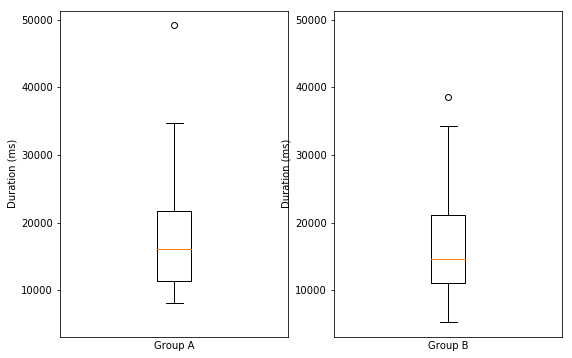

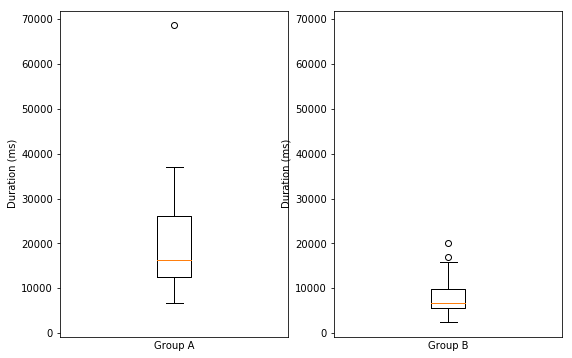

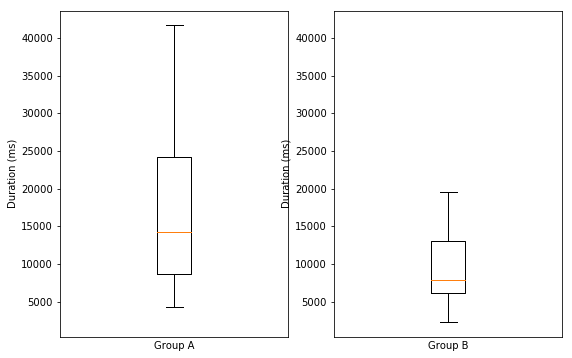

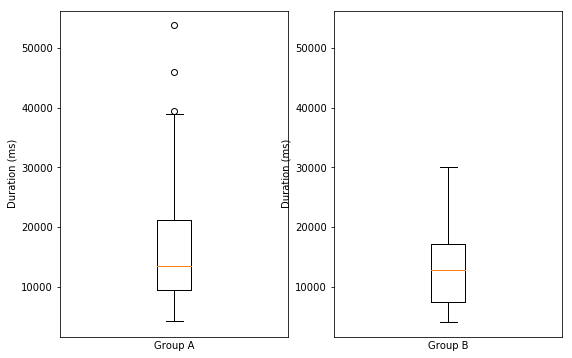

In [220]:
measure = "fixationDurationTotal"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationDurationTotalBoxplot"    
m1 = boxplot("Model 1 total fixation duration", "Duration (ms)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 total fixation duration", "Duration (ms)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 total fixation duration", "Duration (ms)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 total fixation duration", "Duration (ms)", M4A, M4B)
m4.savefig("M4"+db)

IndexError: list index out of range

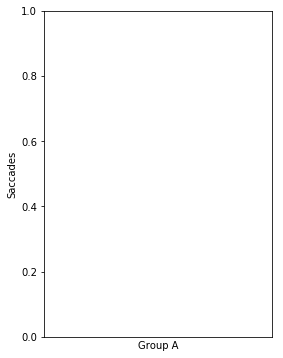

In [221]:
measure = "amountOfSaccades"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "amountOfSaccadesBoxplot"    
m1 = boxplot("Model 1 amount of saccades", "Saccades", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 amount of saccades", "Saccades", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 amount of saccades", "Saccades", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 amount of saccades", "Saccades", M4A, M4B)
m4.savefig("M4"+db)

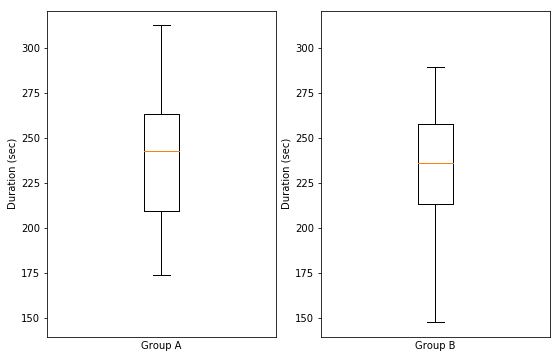

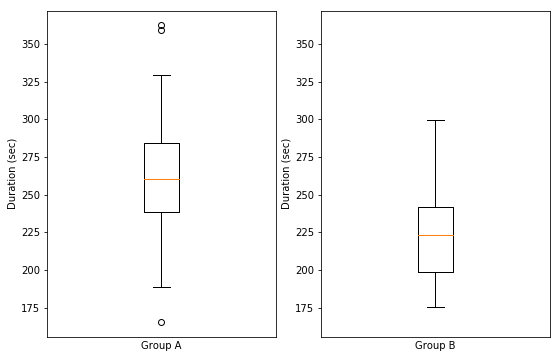

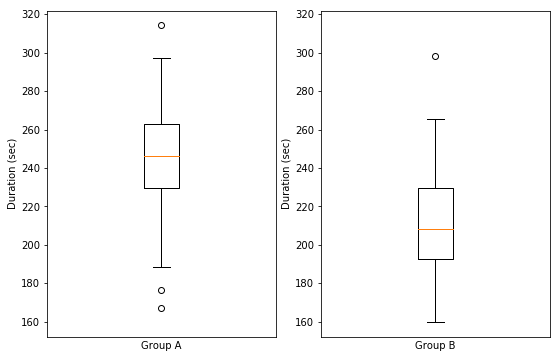

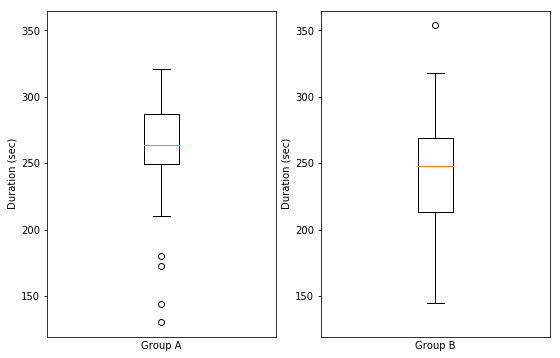

In [223]:
measure = "fixationDuration"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationDurationBoxplot"    
m1 = boxplot("Model 1 fixation duration", "Duration (sec)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 fixation duration", "Duration (sec)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 fixation duration", "Duration (sec)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 fixation duration", "Duration (sec)", M4A, M4B)
m4.savefig("M4"+db)

IndexError: list index out of range

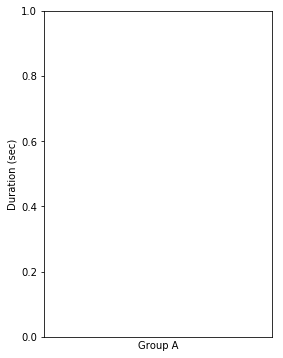

In [224]:
measure = "fixationPrecision"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationDurationBoxplot"    
m1 = boxplot("Model 1 fixation duration", "Duration (sec)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 fixation duration", "Duration (sec)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 fixation duration", "Duration (sec)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 fixation duration", "Duration (sec)", M4A, M4B)
m4.savefig("M4"+db)

IndexError: list index out of range

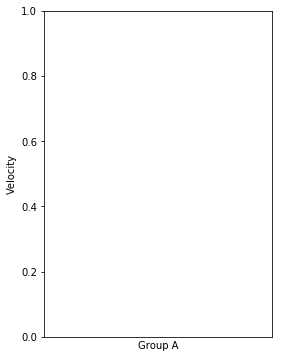

In [225]:
measure = "saccadeVelocityList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "saccadeVelocityBoxplot"    
m1 = boxplot("Model 1 saccade velocity", "Velocity", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 saccade velocity", "Velocity", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 saccade velocity", "Velocity", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 saccade velocity", "Velocity", M4A, M4B)
m4.savefig("M4"+db)

IndexError: list index out of range

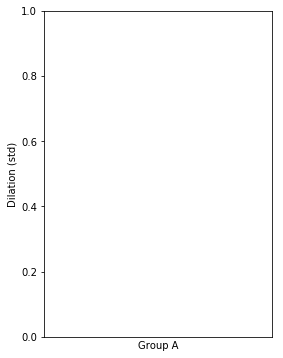

In [226]:
measure = "pupilDilationLeftList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationLeftListBoxplot"    
m1 = boxplot("Model 1 pupil dilation (left eye)", "Dilation (std)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation (left eye)", "Dilation (std)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation (left eye)", "Dilation (std)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation (left eye)", "Dilation (std)", M4A, M4B)
m4.savefig("M4"+db)

IndexError: list index out of range

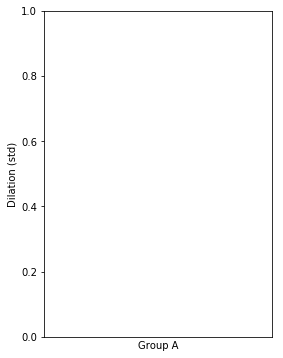

In [227]:
measure = "pupilDilationRightList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationRightListBoxplot"    
m1 = boxplot("Model 1 pupil dilation (right eye)", "Dilation (std)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation (right eye)", "Dilation (std)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation (right eye)", "Dilation (std)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation (right eye)", "Dilation (std)", M4A, M4B)
m4.savefig("M4"+db)

IndexError: list index out of range

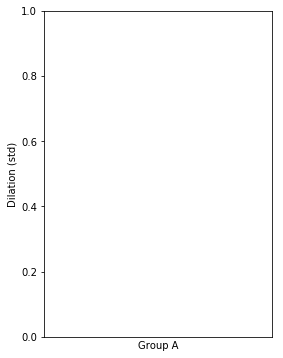

In [228]:
measure = "pupilDilationMean"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationMeanBoxplot"    
m1 = boxplot("Model 1 pupil dilation", "Dilation (std)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation", "Dilation (std)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation", "Dilation (std)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation", "Dilation (std)", M4A, M4B)
m4.savefig("M4"+db)

In [229]:
measure = "pupilDilationDiff"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "pupilDilationDiffBoxplot"    
m1 = boxplot("Model 1 pupil dilation", "Dilation difference", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 pupil dilation", "Dilation difference", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 pupil dilation", "Dilation difference", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 pupil dilation", "Dilation difference", M4A, M4B)
m4.savefig("M4"+db)

KeyError: 'pupilDilationDiff'

IndexError: list index out of range

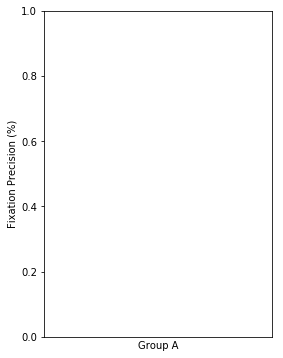

In [230]:
measure = "fixationPrecision"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]


db = "fixationPrecisionBoxplot"    
m1 = boxplot("Model 1 Fixation Precision", "Fixation Precision (%)", M1A, M1B)
m1.savefig("M1"+db)
m2 = boxplot("Model 2 Fixation Precision", "Fixation Precision (%)", M2A, M2B)
m2.savefig("M2"+db)
m3 = boxplot("Model 3 Fixation Precision", "Fixation Precision (%)", M3A, M3B)
m3.savefig("M3"+db)
m4 = boxplot("Model 4 Fixation Precision", "Fixation Precision (%)", M4A, M4B)
m4.savefig("M4"+db)

In [231]:
measure = "duration"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A

print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
duration	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|28842.6923077	|1689.31912389	|14823.7151511	5162.0	70313.0
Non messy direction 	|24539.0769231	|1587.40647156	|13929.4352563	5649.0	66829.0
Messy visibility 	|25783.5512821	|1443.30390968	|12664.9404077	4983.0	84810.0
Non messy visibility 	|21475.6666667	|1668.81365323	|14643.7803763	5239.0	87542.0


In [232]:
measure = "fixationDuration"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A

print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
fixationDuration	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|238.071888993	|3.99158054606	|35.025977141	147.583333333	314.127906977
Non messy direction 	|227.79577165	|4.02238096465	|35.2962497173	159.923076923	312.794871795
Messy visibility 	|254.038614617	|4.8988298511	|42.9870574833	145.225	362.361702128
Non messy visibility 	|242.875438243	|4.70801619635	|41.3126744583	130.653061224	321.353846154


In [233]:
measure = "fixationDurationTotal"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A

print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
fixationDurationTotal	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|17074.0128205	|1063.29396051	|9330.36663678	4339	41664
Non messy direction 	|13910.7820513	|921.567819879	|8086.7248	2285	49144
Messy visibility 	|16776.4615385	|1142.88735595	|10028.7958473	4126	68621
Non messy visibility 	|13210.2435897	|1134.71712192	|9957.10233463	2494	53782


In [234]:
measure = "saccadeVelocityList"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

0
saccadeVelocityList	|Mean		|Std. Error of Mean	|Standard diviation


ValueError: min() arg is an empty sequence

In [235]:
measure = "saccadeVel"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
saccadeVel	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|0.19151144692	|0.00794320133288	|0.0697013088179	0.0892707988311	0.471403815562
Non messy direction 	|0.190896021858	|0.00855156938708	|0.075039716828	0.0858722324793	0.468264662599
Messy visibility 	|0.157439385397	|0.00540381381867	|0.0474182738149	0.0921597502096	0.303586231991
Non messy visibility 	|0.168110052628	|0.00695157991552	|0.0609998661948	0.0871872895623	0.361085589849


In [236]:
measure = "amountOfFixations"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

78
amountOfFixations	|Mean		|Std. Error of Mean	|Standard diviation
Messy direction 	|71.7435897436	|4.21861137704	|37.0181645978	17	182
Non messy direction 	|61.2435897436	|3.7662373914	|33.048598984	11	190
Messy visibility 	|65.7051282051	|4.02345392376	|35.3056648953	15	241
Non messy visibility 	|53.5256410256	|4.10269131713	|36.0009702002	10	214


In [237]:
measure = "pupilDilationMean"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

TUT = data["TUTX-Q01.png"][measure] + data["TUTX-Q02.png"][measure] + data["TUTX-Q03.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(np.var(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(np.var(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(np.var(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(np.var(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))
print ""
print "TUT \t" + str(np.mean(TUT)) + "\t" + str(np.var(TUT)) + "\t" + str(np.std(TUT)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))


KeyError: 'TUTX-Q01.png'

In [238]:
measure = "pupilDilationDiff"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(np.var(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(np.var(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(np.var(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(np.var(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

KeyError: 'pupilDilationDiff'

In [239]:
measure = "fixationPrecision"
M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

messyDirection = M1B + M3A
nonMessyDirection = M1A + M3B
messyVisibility = M2A + M4B
nonMessyVisibility = M2B + M4A
print len(messyDirection)
print measure + "\t|Mean\t\t|Std. Error of Mean\t|Standard diviation"
print "Messy direction \t|" + str(np.mean(messyDirection)) + "\t|" + str(stats.sem(messyDirection)) + "\t|" + str(np.std(messyDirection)) + "\t" + str(min(messyDirection)) + "\t" + str(max(messyDirection))
print "Non messy direction \t|" + str(np.mean(nonMessyDirection)) + "\t|" + str(stats.sem(nonMessyDirection)) + "\t|" + str(np.std(nonMessyDirection)) + "\t" + str(min(nonMessyDirection)) + "\t" + str(max(nonMessyDirection))
print "Messy visibility \t|" + str(np.mean(messyVisibility)) + "\t|" + str(stats.sem(messyVisibility)) + "\t|" + str(np.std(messyVisibility)) + "\t" + str(min(messyVisibility)) + "\t" + str(max(messyVisibility))
print "Non messy visibility \t|" + str(np.mean(nonMessyVisibility)) + "\t|" + str(stats.sem(nonMessyVisibility)) + "\t|" + str(np.std(nonMessyVisibility)) + "\t" + str(min(nonMessyVisibility)) + "\t" + str(max(nonMessyVisibility))

0
fixationPrecision	|Mean		|Std. Error of Mean	|Standard diviation


ValueError: min() arg is an empty sequence

In [240]:
measure = "fixationsPerSecond"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG

print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

0
fixationsPerSecond	|Mean		|Std Error	|Standard diviation
Messy Global 		|nan	|nan	|nan
Messy Local 		|nan	|nan	|nan


ValueError: min() arg is an empty sequence

In [241]:
measure = "fixationDuration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG

print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
fixationDuration	|Mean		|Std Error	|Standard diviation
Messy Global 		|240.819162937	|4.03233473839	|35.3835937274
Messy Local 		|251.291340673	|4.96133411967	|43.5355302141
Non Messy Global 	|236.428005017	|3.0356287877	|37.7932736237	130.653061224	321.353846154
Non Messy Local 	|244.962851734	|3.33787598802	|41.5562209214	145.225	362.361702128


In [242]:
measure = "fixationDurationTotal"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG

print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
fixationDurationTotal	|Mean		|Std Error	|Standard diviation
Messy Global 		|20618.0	|1204.7955221	|10572.0378006
Messy Local 		|13232.474359	|794.753726062	|6973.93564294
Non Messy Global 	|18735.3910256	|842.215711686	|10485.5010503	2494	68621
Non Messy Local 	|11750.3589744	|553.873080745	|6895.6642453	2285	49144


In [243]:
measure = "saccadeVelocityList"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG

print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

0
saccadeVelocityList	|Mean		|Std Error	|Standard diviation
Messy Global 		|nan	|nan	|nan
Messy Local 		|nan	|nan	|nan


ValueError: min() arg is an empty sequence

In [244]:
measure = "duration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL
nonMessyG = M1AG + M3BG + M2BG + M4AG

print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(np.var(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(np.var(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(np.var(nonMessyG)) + "\t|" + str(np.std(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(np.var(nonMessyL)) + "\t|" + str(np.std(nonMessyL))

duration	|Mean		|Variance	|Standard diviation
Messy Global 		|34036.1923077	|199135913.694	|14111.5524906
Messy Local 		|20590.0512821	|95287150.382	|9761.51373415
Non Messy Global 	|29273.9358974	|237121197.316	|15398.7401211
Non Messy Local 	|16740.8076923	|97500862.8476	|9874.25252096


In [245]:
measure = "amountOfFixations"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG
print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
amountOfFixations	|Mean		|Std Error	|Standard diviation
Messy Global 		|84.6025641026	|4.32073810863	|37.9143230305
Messy Local 		|52.8461538462	|3.00072568219	|26.3312609975
Non Messy Global 	|77.9743589744	|3.04054417986	|37.8544697625	10	241
Non Messy Local 	|48.1346153846	|2.14429989651	|26.6963184196	11	190


In [246]:
### measure = "pupilDilationDiff"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG
print len(nonMessyG)
print measure + "\t|Mean\t\t|Variance\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(np.var(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(np.var(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(np.var(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(np.var(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

156
amountOfFixations	|Mean		|Variance	|Standard diviation
Messy Global 		|84.6025641026	|1437.49589086	|37.9143230305
Messy Local 		|52.8461538462	|693.33530572	|26.3312609975
Non Messy Global 	|77.9743589744	|1432.960881	|37.8544697625	10	241
Non Messy Local 	|48.1346153846	|712.69341716	|26.6963184196	11	190


In [247]:
measure = "fixationPrecision"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL + messyL
nonMessyG = M1AG + M3BG + M2BG + M4AG + messyG
print len(nonMessyG)
print measure + "\t|Mean\t\t|Std Error\t|Standard diviation"
print "Messy Global \t\t|" + str(np.mean(messyG)) + "\t|" + str(stats.sem(messyG)) + "\t|" + str(np.std(messyG))
print "Messy Local \t\t|" + str(np.mean(messyL)) + "\t|" + str(stats.sem(messyL)) + "\t|" + str(np.std(messyL))
print "Non Messy Global \t|" + str(np.mean(nonMessyG)) + "\t|" + str(stats.sem(nonMessyG)) + "\t|" + str(np.std(nonMessyG)) + "\t" + str(min(nonMessyG)) + "\t" + str(max(nonMessyG))
print "Non Messy Local \t|" + str(np.mean(nonMessyL)) + "\t|" + str(stats.sem(nonMessyL)) + "\t|" + str(np.std(nonMessyL)) + "\t" + str(min(nonMessyL)) + "\t" + str(max(nonMessyL))

0
fixationPrecision	|Mean		|Std Error	|Standard diviation
Messy Global 		|nan	|nan	|nan
Messy Local 		|nan	|nan	|nan


ValueError: min() arg is an empty sequence

In [248]:
measure = "fixationsPerSecond"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

0
fixationsPerSecond		|Mean		|Std. error	|Standard deviation


ValueError: min() arg is an empty sequence

In [249]:
measure = "fixationDuration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
fixationDuration		|Mean		|Std. error	|Standard deviation
Messy direction global 		|232.02381543	|5.3797613194	|33.1630760099	158.361111111	314.127906977
Non messy direction global 	|226.57078178	|5.76867580927	|35.5605059373	162.345454545	301.731343284
Messy direction local 		|244.119962555	|5.80537444119	|35.7867314978	147.583333333	297.0
Non messy direction local 	|229.02076152	|5.67566296925	|34.9871362838	159.923076923	312.794871795
Messy visibility global 	|249.614510444	|5.7342267045	|35.3481473934	165.414634146	308.804878049
Non messy visibility global 	|237.502912416	|6.89754784898	|42.5193405464	130.653061224	321.353846154
Messy visibility local 		|258.46271879	|7.95900235505	|49.0625855672	145.225	362.361702128
Non messy visibility local 	|248.24796407	|6.38223635479	|39.3427471557	172.91011236	320.981132075


In [250]:
measure = "fixationDurationTotal"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
fixationDurationTotal		|Mean		|Std. error	|Standard deviation
Messy direction global 		|20820.025641	|1527.53411782	|9416.35270587	7271	41664
Non messy direction global 	|16378.3333333	|1170.33095734	|7214.40454153	6360	34693
Messy direction local 		|13328.0	|1228.80516173	|7574.86374592	4339	38536
Non messy direction local 	|11443.2307692	|1323.52186105	|8158.7366935	2285	49144
Messy visibility global 	|20415.974359	|1883.35255044	|11609.7648345	5562	68621
Non messy visibility global 	|17327.2307692	|1983.96373807	|12229.9738484	2494	53782
Messy visibility local 		|13136.9487179	|1024.3707393	|6314.64532958	4126	33065
Non messy visibility local 	|9093.25641026	|624.422819826	|3849.20077431	3699	17012


In [251]:
measure = "fixationDurationTotal"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
fixationDurationTotal		|Mean		|Std. error	|Standard deviation
Messy direction global 		|20820.025641	|1527.53411782	|9416.35270587	7271	41664
Non messy direction global 	|16378.3333333	|1170.33095734	|7214.40454153	6360	34693
Messy direction local 		|13328.0	|1228.80516173	|7574.86374592	4339	38536
Non messy direction local 	|11443.2307692	|1323.52186105	|8158.7366935	2285	49144
Messy visibility global 	|20415.974359	|1883.35255044	|11609.7648345	5562	68621
Non messy visibility global 	|17327.2307692	|1983.96373807	|12229.9738484	2494	53782
Messy visibility local 		|13136.9487179	|1024.3707393	|6314.64532958	4126	33065
Non messy visibility local 	|9093.25641026	|624.422819826	|3849.20077431	3699	17012


In [252]:
measure = "saccadeVel"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
saccadeVel		|Mean		|Std. error	|Standard deviation
Messy direction global 		|0.200380477298	|0.0116252602709	|0.0716629172021	0.124705389579	0.471403815562
Non messy direction global 	|0.19533416306	|0.010539836125	|0.0649719133982	0.101311405987	0.333745751053
Messy direction local 		|0.182642416541	|0.0107894341594	|0.0665105390163	0.0892707988311	0.34164604674
Non messy direction local 	|0.186457880656	|0.0135735564106	|0.0836730212073	0.0858722324793	0.468264662599
Messy visibility global 	|0.168653429041	|0.00806250292458	|0.0497006059273	0.111021277609	0.303586231991
Non messy visibility global 	|0.173351568185	|0.00944500915062	|0.0582229466663	0.110722316095	0.340815863288
Messy visibility local 		|0.146225341753	|0.00683513678285	|0.0421346128964	0.0921597502096	0.25047389492
Non messy visibility local 	|0.162868537071	|0.0102560750449	|0.0632226926221	0.0871872895623	0.361085589849


In [359]:
measure = "amountOfFixations"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
amountOfFixations		|Mean		|Std. error	|Standard deviation
Messy direction global 		|88.5641025641	|5.67433729528	|34.9789642806	34	182
Non messy direction global 	|72.8205128205	|4.78708222912	|29.5095567266	26	139
Messy direction local 		|54.9230769231	|5.00342455132	|30.8431803669	17	169
Non messy direction local 	|49.6666666667	|5.24543800679	|32.3350515007	11	190
Messy visibility global 	|80.641025641	|6.52943994055	|40.2501710011	22	241
Non messy visibility global 	|69.8717948718	|6.89385294917	|42.4965636542	10	214
Messy visibility local 		|50.7692307692	|3.35112556644	|20.6577253675	15	96
Non messy visibility local 	|37.1794871795	|2.57410330413	|15.8678384531	13	91


In [360]:
print data["M3B-Q15.png"]["duration"]

[6109.0, 5810.0, 6301.0, 5649.0, 10547.0, 8112.0]


In [361]:
measure = "duration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print len(messyDirectionGlobal)
print measure + "\t|Mean\t\t|Variance\t|Standard deviation"
print "Messy direction global \t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(np.var(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(np.var(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(np.var(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(np.var(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(np.var(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(np.var(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(np.var(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(np.var(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

39
duration	|Mean		|Variance	|Standard deviation
Messy direction global 	|37206.6666667	|178059151.043	|13343.880659	9289.0	70313.0
Non messy direction global 	|31407.4358974	|168788184.81	|12991.8507077	11246.0	64504.0
Messy direction local 	|20478.7179487	|121513776.561	|11023.3287423	5162.0	54807.0
Non messy direction local 	|17670.7179487	|124921438.305	|11176.8259495	5649.0	66829.0
Messy visibility global 	|30865.7179487	|200108861.023	|14145.9839185	10154.0	84810.0
Non messy visibility global 	|27140.4358974	|296350565.323	|17214.8356171	5239.0	87542.0
Messy visibility local 	|20701.3846154	|69035733.9803	|8308.77451736	4983.0	40268.0
Non messy visibility local 	|15810.8974359	|68350821.2202	|8267.45554692	5793.0	43841.0


In [362]:
measure = "accuracy"
M1AL = []
for index in xrange(len(data["M1A-Q01.png"][measure])):
    M1AL.append(data["M1A-Q01.png"][measure][index]+data["M1A-Q02.png"][measure][index]+data["M1A-Q03.png"][measure][index])
M1AG = []
for index in xrange(len(data["M1A-Q04.png"][measure])):
    M1AG.append(data["M1A-Q04.png"][measure][index]+data["M1A-Q05.png"][measure][index]+data["M1A-Q06.png"][measure][index])
M1BL = []
for index in xrange(len(data["M1B-Q01.png"][measure])):
    M1BL.append(data["M1B-Q01.png"][measure][index]+data["M1B-Q02.png"][measure][index]+data["M1B-Q03.png"][measure][index])
M1BG = []
for index in xrange(len(data["M1B-Q04.png"][measure])):
    M1BG.append(data["M1B-Q04.png"][measure][index]+data["M1B-Q05.png"][measure][index]+data["M1B-Q06.png"][measure][index])
M2AL = []
for index in xrange(len(data["M2A-Q07.png"][measure])):
    M2AL.append(data["M2A-Q07.png"][measure][index]+data["M2A-Q08.png"][measure][index]+data["M2A-Q09.png"][measure][index])
M2AG = []
for index in xrange(len(data["M2A-Q10.png"][measure])):
    M2AG.append(data["M2A-Q10.png"][measure][index]+data["M2A-Q11.png"][measure][index]+data["M2A-Q12.png"][measure][index])
M2BL = []
for index in xrange(len(data["M2B-Q07.png"][measure])):
    M2BL.append(data["M2B-Q07.png"][measure][index]+data["M2B-Q08.png"][measure][index]+data["M2B-Q09.png"][measure][index])
M2BG = []
for index in xrange(len(data["M2B-Q10.png"][measure])):
    M2BG.append(data["M2B-Q10.png"][measure][index]+data["M2B-Q11.png"][measure][index]+data["M2B-Q12.png"][measure][index])
M3AL = []
for index in xrange(len(data["M3A-Q13.png"][measure])):
    M3AL.append(data["M3A-Q13.png"][measure][index]+data["M3A-Q14.png"][measure][index]+data["M3A-Q15.png"][measure][index])
M3AG = []
for index in xrange(len(data["M3A-Q16.png"][measure])):
    M3AG.append(data["M3A-Q16.png"][measure][index]+data["M3A-Q17.png"][measure][index]+data["M3A-Q18.png"][measure][index])
M3BL = []
for index in xrange(len(data["M3B-Q13.png"][measure])):
    M3BL.append(data["M3B-Q13.png"][measure][index]+data["M3B-Q14.png"][measure][index]+data["M3B-Q15.png"][measure][index])
M3BG = []
for index in xrange(len(data["M3B-Q16.png"][measure])):
    M3BG.append(data["M3B-Q16.png"][measure][index]+data["M3B-Q17.png"][measure][index]+data["M3B-Q18.png"][measure][index])
M4AL = []
for index in xrange(len(data["M4A-Q19.png"][measure])):
    M4AL.append(data["M4A-Q19.png"][measure][index]+data["M4A-Q20.png"][measure][index]+data["M4A-Q24.png"][measure][index])
M4AG = []
for index in xrange(len(data["M4A-Q22.png"][measure])):
    M4AG.append(data["M4A-Q22.png"][measure][index]+data["M4A-Q23.png"][measure][index]+data["M4A-Q21.png"][measure][index])
M4BL = []
for index in xrange(len(data["M4B-Q19.png"][measure])):
    M4BL.append(data["M4B-Q19.png"][measure][index]+data["M4B-Q20.png"][measure][index]+data["M4B-Q24.png"][measure][index])
M4BG = []
for index in xrange(len(data["M4B-Q22.png"][measure])):
    M4BG.append(data["M4B-Q22.png"][measure][index]+data["M4B-Q23.png"][measure][index]+data["M4B-Q21.png"][measure][index])

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t|Mean\t\t|Variance\t|Standard deviation"
print "Messy direction global \t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(np.var(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(np.var(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(np.var(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(np.var(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(np.var(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(np.var(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(np.var(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(np.var(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

13
accuracy	|Mean		|Variance	|Standard deviation
Messy direction global 	|2.0	|1.07692307692	|1.03774904333	0	3
Non messy direction global 	|2.0	|0.615384615385	|0.784464540553	1	3
Messy direction local 	|2.61538461538	|0.698224852071	|0.835598499323	0	3
Non messy direction local 	|2.38461538462	|0.544378698225	|0.737820234356	1	3
Messy visibility global 	|2.15384615385	|0.591715976331	|0.769230769231	1	3
Non messy visibility global 	|2.15384615385	|0.591715976331	|0.769230769231	1	3
Messy visibility local 	|2.92307692308	|0.0710059171598	|0.266469355011	2	3
Non messy visibility local 	|2.69230769231	|0.366863905325	|0.605692913386	1	3


In [257]:
measure = "pupilDilationDiff"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t|Mean\t\t|Variance\t|Standard deviation"
print "Messy direction global \t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(np.var(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(np.var(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(np.var(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(np.var(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(np.var(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(np.var(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(np.var(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(np.var(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

KeyError: 'pupilDilationDiff'

In [258]:
measure = "fixationPrecision"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL
print len(messyDirectionGlobal)
print measure + "\t\t|Mean\t\t|Std. error\t|Standard deviation"
print "Messy direction global \t\t|" + str(np.mean(messyDirectionGlobal)) + "\t|" + str(stats.sem(messyDirectionGlobal)) + "\t|" + str(np.std(messyDirectionGlobal)) + "\t" + str(min(messyDirectionGlobal)) + "\t" + str(max(messyDirectionGlobal))
print "Non messy direction global \t|" + str(np.mean(nonMessyDirectionGlobal)) + "\t|" + str(stats.sem(nonMessyDirectionGlobal)) + "\t|" + str(np.std(nonMessyDirectionGlobal)) + "\t" + str(min(nonMessyDirectionGlobal)) + "\t" + str(max(nonMessyDirectionGlobal))
print "Messy direction local \t\t|" + str(np.mean(messyDirectionLocal)) + "\t|" + str(stats.sem(messyDirectionLocal)) + "\t|" + str(np.std(messyDirectionLocal)) + "\t" + str(min(messyDirectionLocal)) + "\t" + str(max(messyDirectionLocal))
print "Non messy direction local \t|" + str(np.mean(nonMessyDirectionLocal)) + "\t|" + str(stats.sem(nonMessyDirectionLocal)) + "\t|" + str(np.std(nonMessyDirectionLocal)) + "\t" + str(min(nonMessyDirectionLocal)) + "\t" + str(max(nonMessyDirectionLocal))
print "Messy visibility global \t|" + str(np.mean(messyVisibilityGlobal)) + "\t|" + str(stats.sem(messyVisibilityGlobal)) + "\t|" + str(np.std(messyVisibilityGlobal)) + "\t" + str(min(messyVisibilityGlobal)) + "\t" + str(max(messyVisibilityGlobal))
print "Non messy visibility global \t|" + str(np.mean(nonMessyVisibilityGlobal)) + "\t|" + str(stats.sem(nonMessyVisibilityGlobal)) + "\t|" + str(np.std(nonMessyVisibilityGlobal)) + "\t" + str(min(nonMessyVisibilityGlobal)) + "\t" + str(max(nonMessyVisibilityGlobal))
print "Messy visibility local \t\t|" + str(np.mean(messyVisibilityLocal)) + "\t|" + str(stats.sem(messyVisibilityLocal)) + "\t|" + str(np.std(messyVisibilityLocal)) + "\t" + str(min(messyVisibilityLocal)) + "\t" + str(max(messyVisibilityLocal))
print "Non messy visibility local \t|" + str(np.mean(nonMessyVisibilityLocal)) + "\t|" + str(stats.sem(nonMessyVisibilityLocal)) + "\t|" + str(np.std(nonMessyVisibilityLocal)) + "\t" + str(min(nonMessyVisibilityLocal)) + "\t" + str(max(nonMessyVisibilityLocal))

0
fixationPrecision		|Mean		|Std. error	|Standard deviation


ValueError: min() arg is an empty sequence

In [259]:
measureList = ["amountOfFixations", "fixationsPerSecond", "fixationDuration", "saccadeVelocityList", "fixationPrecision", "pupilDilationDiff"]

In [260]:
measureList = ["amountOfFixations", "fixationDurationTotal", "saccadeVel", "pupilDilationDiff"]

In [261]:
#high change of direction
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M1B+M3A
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.932	78	0.000	No
fixationDurationTotal	0.912	78	0.000	No
saccadeVel	0.862	78	0.000	No


KeyError: 'pupilDilationDiff'

In [262]:
#low change of direction
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M1A + M3B
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.926	78	0.000	No
fixationDurationTotal	0.896	78	0.000	No
saccadeVel	0.849	78	0.000	No


KeyError: 'pupilDilationDiff'

In [263]:
#low block visibility
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M2A + M4B
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.885	78	0.000	No
fixationDurationTotal	0.845	78	0.000	No
saccadeVel	0.903	78	0.000	No


KeyError: 'pupilDilationDiff'

In [264]:
#high block visibility
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1A = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] +data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1B = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] +data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2A = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] +data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2B = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] +data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3A = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] +data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3B = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] +data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4A = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q21.png"][measure] +data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q24.png"][measure]
    M4B = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q21.png"][measure] +data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q24.png"][measure]

    collectedLists = M2B + M4A
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.818	78	0.000	No
fixationDurationTotal	0.784	78	0.000	No
saccadeVel	0.878	78	0.000	No


KeyError: 'pupilDilationDiff'

In [265]:
#local questions
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyL = M1BL + M3AL + M2AL + M4BL
    messyG = M1BG + M3AG + M2AG + M4BG
    nonMessyL = M1AL + M3BL + M2BL + M4AL
    nonMessyG = M1AG + M3BG + M2BG + M4AG
    
    collectedLists = messyL + nonMessyL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.852	156	0.000	No
fixationDurationTotal	0.850	156	0.000	No
saccadeVel	0.843	156	0.000	No


KeyError: 'pupilDilationDiff'

In [266]:
#global questions
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyL = M1BL + M3AL + M2AL + M4BL
    messyG = M1BG + M3AG + M2AG + M4BG
    nonMessyL = M1AL + M3BL + M2BL + M4AL
    nonMessyG = M1AG + M3BG + M2BG + M4AG
    
    collectedLists = messyG + nonMessyG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.939	156	0.000	No
fixationDurationTotal	0.912	156	0.000	No
saccadeVel	0.873	156	0.000	No


KeyError: 'pupilDilationDiff'

In [267]:
# high change of direction local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1BL + M3AL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.830	39	0.000	No
fixationDurationTotal	0.855	39	0.000	No
saccadeVel	0.879	39	0.001	No


KeyError: 'pupilDilationDiff'

In [268]:
# high change of direction global
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1BG + M3AG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.959	39	0.166	Yes
fixationDurationTotal	0.939	39	0.034	No
saccadeVel	0.785	39	0.000	No


KeyError: 'pupilDilationDiff'

In [269]:
# low change of direction local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1AL + M3BL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.808	39	0.000	No
fixationDurationTotal	0.769	39	0.000	No
saccadeVel	0.766	39	0.000	No


KeyError: 'pupilDilationDiff'

In [270]:
# low change of direction gobal
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M1AG + M3BG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.954	39	0.108	Yes
fixationDurationTotal	0.929	39	0.016	No
saccadeVel	0.901	39	0.002	No


KeyError: 'pupilDilationDiff'

In [271]:
# low block visibility local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2AL + M4BL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.976	39	0.573	Yes
fixationDurationTotal	0.902	39	0.002	No
saccadeVel	0.908	39	0.004	No


KeyError: 'pupilDilationDiff'

In [272]:
# low block visibility global
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2AG + M4BG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.892	39	0.001	No
fixationDurationTotal	0.860	39	0.000	No
saccadeVel	0.861	39	0.000	No


KeyError: 'pupilDilationDiff'

In [273]:
# high block visibility local
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2BL + M4AL
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.926	39	0.014	No
fixationDurationTotal	0.936	39	0.028	No
saccadeVel	0.868	39	0.000	No


KeyError: 'pupilDilationDiff'

In [274]:
# high block visibility global
#measure = "fixationsPerSecond"
#fixationsPerSecond = M1B + M3A

for measurement in measureList:
    measure = measurement
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL
    
    collectedLists = M2BG + M4AG
    statistic, pval = stats.shapiro(collectedLists)
    verdict = ""
    if(pval < 0.055):
        verdict = "No"
    else:
        verdict = "Yes"
    
    print measure + "\t" + "%.3f" % (statistic,) + "\t" + str(len(collectedLists)) + "\t" + "%0.3f" % (pval,) + "\t" + verdict

amountOfFixations	0.886	39	0.001	No
fixationDurationTotal	0.866	39	0.000	No
saccadeVel	0.864	39	0.000	No


KeyError: 'pupilDilationDiff'

In [275]:
measure = "amountOfFixations"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyL = M1BL + M3AL + M2AL + M4BL
messyG = M1BG + M3AG + M2AG + M4BG
nonMessyL = M1AL + M3BL + M2BL + M4AL
nonMessyG = M1AG + M3BG + M2BG + M4AG
allFixations = messyL+messyG+nonMessyL+nonMessyG

stats.shapiro(allFixations)

(0.9049729108810425, 4.16068113122392e-13)

In [276]:
measure = "duration"
M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
M1AG = data["M1A-Q04.png"][measure] +data["M1A-Q05.png"][measure] +data["M1A-Q06.png"][measure]
M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
M1BG = data["M1B-Q04.png"][measure] +data["M1B-Q05.png"][measure] +data["M1B-Q06.png"][measure]
M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
M2AG = data["M2A-Q10.png"][measure] +data["M2A-Q11.png"][measure] +data["M2A-Q12.png"][measure]
M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
M2BG = data["M2B-Q10.png"][measure] +data["M2B-Q11.png"][measure] +data["M2B-Q12.png"][measure]
M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
M3AG = data["M3A-Q16.png"][measure] +data["M3A-Q17.png"][measure] +data["M3A-Q18.png"][measure]
M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
M3BG = data["M3B-Q16.png"][measure] +data["M3B-Q17.png"][measure] +data["M3B-Q18.png"][measure]
M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
M4AG = data["M4A-Q22.png"][measure] +data["M4A-Q23.png"][measure] +data["M4A-Q21.png"][measure]
M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
M4BG = data["M4B-Q22.png"][measure] +data["M4B-Q23.png"][measure] +data["M4B-Q21.png"][measure]

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG 
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print stats.shapiro(messyDirectionGlobal)
print stats.shapiro(messyDirectionLocal)
print stats.shapiro(nonMessyDirectionGlobal)
print stats.shapiro(nonMessyDirectionLocal)
print stats.shapiro(messyVisibilityGlobal)
print stats.shapiro(messyVisibilityLocal)
print stats.shapiro(nonMessyVisibilityGlobal)
print stats.shapiro(nonMessyVisibilityLocal)

(0.9895576238632202, 0.971298098564148)
(0.8894631862640381, 0.0011157650733366609)
(0.9559559226036072, 0.13048607110977173)
(0.7929587364196777, 6.037948423909256e-06)
(0.9103532433509827, 0.0044300551526248455)
(0.9730882048606873, 0.46454840898513794)
(0.8508116602897644, 0.00011317837925162166)
(0.8891229629516602, 0.0010919627966359258)


In [277]:
measure = "accuracy"
M1AL = []
for index in xrange(len(data["M1A-Q01.png"][measure])):
    M1AL.append(data["M1A-Q01.png"][measure][index]+data["M1A-Q02.png"][measure][index]+data["M1A-Q03.png"][measure][index])
M1AG = []
for index in xrange(len(data["M1A-Q04.png"][measure])):
    M1AG.append(data["M1A-Q04.png"][measure][index]+data["M1A-Q05.png"][measure][index]+data["M1A-Q06.png"][measure][index])
M1BL = []
for index in xrange(len(data["M1B-Q01.png"][measure])):
    M1BL.append(data["M1B-Q01.png"][measure][index]+data["M1B-Q02.png"][measure][index]+data["M1B-Q03.png"][measure][index])
M1BG = []
for index in xrange(len(data["M1B-Q04.png"][measure])):
    M1BG.append(data["M1B-Q04.png"][measure][index]+data["M1B-Q05.png"][measure][index]+data["M1B-Q06.png"][measure][index])
M2AL = []
for index in xrange(len(data["M2A-Q07.png"][measure])):
    M2AL.append(data["M2A-Q07.png"][measure][index]+data["M2A-Q08.png"][measure][index]+data["M2A-Q09.png"][measure][index])
M2AG = []
for index in xrange(len(data["M2A-Q10.png"][measure])):
    M2AG.append(data["M2A-Q10.png"][measure][index]+data["M2A-Q11.png"][measure][index]+data["M2A-Q12.png"][measure][index])
M2BL = []
for index in xrange(len(data["M2B-Q07.png"][measure])):
    M2BL.append(data["M2B-Q07.png"][measure][index]+data["M2B-Q08.png"][measure][index]+data["M2B-Q09.png"][measure][index])
M2BG = []
for index in xrange(len(data["M2B-Q10.png"][measure])):
    M2BG.append(data["M2B-Q10.png"][measure][index]+data["M2B-Q11.png"][measure][index]+data["M2B-Q12.png"][measure][index])
M3AL = []
for index in xrange(len(data["M3A-Q13.png"][measure])):
    M3AL.append(data["M3A-Q13.png"][measure][index]+data["M3A-Q14.png"][measure][index]+data["M3A-Q15.png"][measure][index])
M3AG = []
for index in xrange(len(data["M3A-Q16.png"][measure])):
    M3AG.append(data["M3A-Q16.png"][measure][index]+data["M3A-Q17.png"][measure][index]+data["M3A-Q18.png"][measure][index])
M3BL = []
for index in xrange(len(data["M3B-Q13.png"][measure])):
    M3BL.append(data["M3B-Q13.png"][measure][index]+data["M3B-Q14.png"][measure][index]+data["M3B-Q15.png"][measure][index])
M3BG = []
for index in xrange(len(data["M3B-Q16.png"][measure])):
    M3BG.append(data["M3B-Q16.png"][measure][index]+data["M3B-Q17.png"][measure][index]+data["M3B-Q18.png"][measure][index])
M4AL = []
for index in xrange(len(data["M4A-Q19.png"][measure])):
    M4AL.append(data["M4A-Q19.png"][measure][index]+data["M4A-Q20.png"][measure][index]+data["M4A-Q24.png"][measure][index])
M4AG = []
for index in xrange(len(data["M4A-Q22.png"][measure])):
    M4AG.append(data["M4A-Q22.png"][measure][index]+data["M4A-Q23.png"][measure][index]+data["M4A-Q21.png"][measure][index])
M4BL = []
for index in xrange(len(data["M4B-Q19.png"][measure])):
    M4BL.append(data["M4B-Q19.png"][measure][index]+data["M4B-Q20.png"][measure][index]+data["M4B-Q24.png"][measure][index])
M4BG = []
for index in xrange(len(data["M4B-Q22.png"][measure])):
    M4BG.append(data["M4B-Q22.png"][measure][index]+data["M4B-Q23.png"][measure][index]+data["M4B-Q21.png"][measure][index])

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

print stats.shapiro(messyDirectionGlobal)
print stats.shapiro(messyDirectionLocal)
print stats.shapiro(nonMessyDirectionGlobal)
print stats.shapiro(nonMessyDirectionLocal)
print stats.shapiro(messyVisibilityGlobal)
print stats.shapiro(messyVisibilityLocal)
print stats.shapiro(nonMessyVisibilityGlobal)
print stats.shapiro(nonMessyVisibilityLocal)

(0.8114262223243713, 0.009347505867481232)
(0.5240042209625244, 1.5539282685494982e-05)
(0.8194588422775269, 0.011717051267623901)
(0.7558441758155823, 0.002134317997843027)
(0.8122488260269165, 0.009564883075654507)
(0.31100672483444214, 5.044599902248592e-07)
(0.8122488260269165, 0.009564883075654507)
(0.5674636363983154, 3.47693930962123e-05)


In [278]:
data["M1A-Q01.png"]["pupilDilationDiff"]

KeyError: 'pupilDilationDiff'

In [279]:
import scipy.stats as stats
stats.shapiro(M1BG+M3AG+M1AG+M3BG)

(0.8301495909690857, 0.000600386701989919)

In [280]:
data["M1A-Q01.png"].keys()

['fixationDuration',
 'fixationPrecision',
 'saccadeVelocityList',
 'accuracy',
 'saccadeDur',
 'fixationsPerSecond',
 'saccadeVel',
 'pupilDilationLeftList',
 'amountOfSaccades',
 'saccadeAmp',
 'duration',
 'pupilDilationMean',
 'fixationDurationTotal',
 'saccadeDurationList',
 'pupilDilationRightList',
 'amountOfFixations']

In [281]:
data.keys()

['M4A-Q24.png',
 'M4A-Q21.png',
 'M4A-Q22.png',
 'M4A-Q23.png',
 'M4B-Q24.png',
 'M3A-Q18.png',
 'M2A-Q09.png',
 'M3B-Q18.png',
 'M1B-Q06.png',
 'M3B-Q13.png',
 'M2A-Q12.png',
 'M2B-Q12.png',
 'M2A-Q10.png',
 'M3B-Q17.png',
 'M4A-Q20.png',
 'M4B-Q23.png',
 'M4B-Q22.png',
 'M4B-Q20.png',
 'M1A-Q04.png',
 'M1A-Q06.png',
 'M2A-Q08.png',
 'M1B-Q02.png',
 'M4A-Q19.png',
 'M2B-Q10.png',
 'M2A-Q11.png',
 'M3A-Q13.png',
 'M1B-Q01.png',
 'M1A-Q01.png',
 'M1B-Q03.png',
 'M4B-Q21.png',
 'M1A-Q02.png',
 'M1A-Q05.png',
 'M4B-Q19.png',
 'M1B-Q05.png',
 'M3A-Q15.png',
 'M3A-Q16.png',
 'M3A-Q17.png',
 'M2B-Q07.png',
 'M1A-Q03.png',
 'M1B-Q04.png',
 'M2B-Q09.png',
 'M2B-Q08.png',
 'M2B-Q11.png',
 'M3B-Q14.png',
 'M3A-Q14.png',
 'M3B-Q16.png',
 'M3B-Q15.png',
 'M2A-Q07.png']

In [282]:
dataHeaders

['\xef\xbb\xbfExportDate',
 'StudioVersionRec',
 'StudioProjectName',
 'StudioTestName',
 'ParticipantName',
 '[M1BE-Q1]Value',
 '[M1BE-Q2]Value',
 '[M1BE-Q3]Value',
 '[M1BE-Q4]Value',
 '[M1BE-Q5]Value',
 '[M1BE-Q6]Value',
 '[M1B-Q01]Value',
 '[M1B-Q02]Value',
 '[M1B-Q03]Value',
 '[M1B-Q04]Value',
 '[M1B-Q05]Value',
 '[M1B-Q06]Value',
 '[M2BE-Q10]Value',
 '[M2BE-Q11]Value',
 '[M2BE-Q12]Value',
 '[M2BE-Q7]Value',
 '[M2BE-Q8]Value',
 '[M2BE-Q9]Value',
 '[M2B-Q07]Value',
 '[M2B-Q08]Value',
 '[M2B-Q09]Value',
 '[M2B-Q10]Value',
 '[M2B-Q11]Value',
 '[M2B-Q12]Value',
 '[M3BE-Q13]Value',
 '[M3BE-Q14]Value',
 '[M3BE-Q15]Value',
 '[M3BE-Q16]Value',
 '[M3BE-Q17]Value',
 '[M3BE-Q18]Value',
 '[M3B-Q13]Value',
 '[M3B-Q14]Value',
 '[M3B-Q15]Value',
 '[M3B-Q16]Value',
 '[M3B-Q17]Value',
 '[M3B-Q18]Value',
 '[M4BE-Q19]Value',
 '[M4BE-Q20]Value',
 '[M4BE-Q21]Value',
 '[M4BE-Q22]Value',
 '[M4BE-Q23]Value',
 '[M4BE-Q24]Value',
 '[M4B-Q19]Value',
 '[M4B-Q20]Value',
 '[M4B-Q21]Value',
 '[M4B-Q22]Value',
 '

In [283]:
print tutMean

NameError: name 'tutMean' is not defined

In [284]:
data["M1"]

KeyError: 'M1'

In [285]:
import statsmodels


In [367]:
def changeMeasure(measure):
    M1AL = data["M1A-Q01.png"][measure] + data["M1A-Q02.png"][measure] + data["M1A-Q03.png"][measure] 
    M1AG = data["M1A-Q04.png"][measure] + data["M1A-Q05.png"][measure] + data["M1A-Q06.png"][measure]
    M1BL = data["M1B-Q01.png"][measure] + data["M1B-Q02.png"][measure] + data["M1B-Q03.png"][measure] 
    M1BG = data["M1B-Q04.png"][measure] + data["M1B-Q05.png"][measure] + data["M1B-Q06.png"][measure]
    M2AL = data["M2A-Q07.png"][measure] + data["M2A-Q08.png"][measure] + data["M2A-Q09.png"][measure] 
    M2AG = data["M2A-Q10.png"][measure] + data["M2A-Q11.png"][measure] + data["M2A-Q12.png"][measure]
    M2BL = data["M2B-Q07.png"][measure] + data["M2B-Q08.png"][measure] + data["M2B-Q09.png"][measure] 
    M2BG = data["M2B-Q10.png"][measure] + data["M2B-Q11.png"][measure] + data["M2B-Q12.png"][measure]
    M3AL = data["M3A-Q13.png"][measure] + data["M3A-Q14.png"][measure] + data["M3A-Q15.png"][measure] 
    M3AG = data["M3A-Q16.png"][measure] + data["M3A-Q17.png"][measure] + data["M3A-Q18.png"][measure]
    M3BL = data["M3B-Q13.png"][measure] + data["M3B-Q14.png"][measure] + data["M3B-Q15.png"][measure] 
    M3BG = data["M3B-Q16.png"][measure] + data["M3B-Q17.png"][measure] + data["M3B-Q18.png"][measure]
    M4AL = data["M4A-Q19.png"][measure] + data["M4A-Q20.png"][measure] + data["M4A-Q24.png"][measure] 
    M4AG = data["M4A-Q22.png"][measure] + data["M4A-Q23.png"][measure] + data["M4A-Q21.png"][measure]
    M4BL = data["M4B-Q19.png"][measure] + data["M4B-Q20.png"][measure] + data["M4B-Q24.png"][measure] 
    M4BG = data["M4B-Q22.png"][measure] + data["M4B-Q23.png"][measure] + data["M4B-Q21.png"][measure]

    global messyDirectionGlobal
    global nonMessyDirectionGlobal
    global messyDirectionLocal
    global nonMessyDirectionLocal
    global messyVisibilityGlobal
    global nonMessyVisibilityGlobal
    global messyVisibilityLocal
    global nonMessyVisibilityLocal
    
    
    messyDirectionGlobal = M1BG + M3AG
    nonMessyDirectionGlobal = M1AG + M3BG
    messyDirectionLocal = M1BL + M3AL
    nonMessyDirectionLocal = M1AL + M3BL
    messyVisibilityGlobal = M2AG + M4BG
    nonMessyVisibilityGlobal = M2BG + M4AG
    messyVisibilityLocal = M2AL + M4BL
    nonMessyVisibilityLocal = M2BL + M4AL

In [368]:
changeMeasure("saccadeDur")
#print messyDirectionGlobal

In [287]:
def statisticalTest(data1, data2, normalDistributed):       
    statistic = 0
    pval = 0
    if normalDistributed is True:
        #Parametric test
        #statistic, pval = statsmodels.test(data1,data2,paired=True)
        statistic, pval = stats.stats.ttest_rel(data1, data2)
    else: 
        #Non-parametric test
        statistic, pval = stats.wilcoxon(data1,data2)
    return statistic, pval

In [288]:
#Change of direction - High Global vs Low Global
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 1.888 0.067
fixationsPerSecond nan nan
fixationDurationTotal 260.000 0.070
fixationPrecision nan nan
saccadeVel 364.000 0.717


KeyError: 'pupilDilationDiff'

In [289]:
#Change of direction - High Local vs Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 282.500 0.202
fixationsPerSecond nan nan
fixationDurationTotal 233.000 0.028
fixationPrecision nan nan
saccadeVel 360.000 0.675


KeyError: 'pupilDilationDiff'

In [290]:
#Block visibility - High Global vs Low Global
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 265.000 0.192
fixationsPerSecond nan nan
fixationDurationTotal 303.000 0.225
fixationPrecision nan nan
saccadeVel 374.000 0.823


KeyError: 'pupilDilationDiff'

In [291]:
#Block visibility - High Local vs Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 187.000 0.005
fixationsPerSecond nan nan
fixationDurationTotal 200.000 0.008
fixationPrecision nan nan
saccadeVel 314.000 0.289


KeyError: 'pupilDilationDiff'

In [292]:
#Type of question - Change of Direction High Global vs Change of Direction High Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 135.500 0.000
fixationsPerSecond nan nan
fixationDurationTotal 151.000 0.001
fixationPrecision nan nan
saccadeVel 284.000 0.139


KeyError: 'pupilDilationDiff'

In [293]:
#Type of question - Change of Direction Low Global vs Change of Direction Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 130.500 0.000
fixationsPerSecond nan nan
fixationDurationTotal 138.000 0.000
fixationPrecision nan nan
saccadeVel 311.000 0.270


KeyError: 'pupilDilationDiff'

In [294]:
#Type of question - Block Visibility Low Global vs Block Visibility Low Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 69.000 0.000
fixationsPerSecond nan nan
fixationDurationTotal 121.000 0.000
fixationPrecision nan nan
saccadeVel 241.000 0.038


KeyError: 'pupilDilationDiff'

In [295]:
#Type of question - Block visibility High Global vs Block visibility High Local
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixations per second
measure = "fixationsPerSecond"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation precision
measure = "fixationPrecision"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVel"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 72.500 0.000
fixationsPerSecond nan nan
fixationDurationTotal 94.000 0.000
fixationPrecision nan nan
saccadeVel 324.000 0.357


KeyError: 'pupilDilationDiff'

In [296]:
measure = "duration"
changeMeasure(measure)
statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

duration 1.642 0.109
duration 264.000 0.079
duration 297.000 0.194
duration 231.000 0.026
duration 75.000 0.000
duration 5.788 0.000
duration 100.000 0.000
duration 92.000 0.000


In [297]:
measure = "accuracy"
M1AL = []
for index in xrange(len(data["M1A-Q01.png"][measure])):
    M1AL.append(data["M1A-Q01.png"][measure][index]+data["M1A-Q02.png"][measure][index]+data["M1A-Q03.png"][measure][index])
M1AG = []
for index in xrange(len(data["M1A-Q04.png"][measure])):
    M1AG.append(data["M1A-Q04.png"][measure][index]+data["M1A-Q05.png"][measure][index]+data["M1A-Q06.png"][measure][index])
M1BL = []
for index in xrange(len(data["M1B-Q01.png"][measure])):
    M1BL.append(data["M1B-Q01.png"][measure][index]+data["M1B-Q02.png"][measure][index]+data["M1B-Q03.png"][measure][index])
M1BG = []
for index in xrange(len(data["M1B-Q04.png"][measure])):
    M1BG.append(data["M1B-Q04.png"][measure][index]+data["M1B-Q05.png"][measure][index]+data["M1B-Q06.png"][measure][index])
M2AL = []
for index in xrange(len(data["M2A-Q07.png"][measure])):
    M2AL.append(data["M2A-Q07.png"][measure][index]+data["M2A-Q08.png"][measure][index]+data["M2A-Q09.png"][measure][index])
M2AG = []
for index in xrange(len(data["M2A-Q10.png"][measure])):
    M2AG.append(data["M2A-Q10.png"][measure][index]+data["M2A-Q11.png"][measure][index]+data["M2A-Q12.png"][measure][index])
M2BL = []
for index in xrange(len(data["M2B-Q07.png"][measure])):
    M2BL.append(data["M2B-Q07.png"][measure][index]+data["M2B-Q08.png"][measure][index]+data["M2B-Q09.png"][measure][index])
M2BG = []
for index in xrange(len(data["M2B-Q10.png"][measure])):
    M2BG.append(data["M2B-Q10.png"][measure][index]+data["M2B-Q11.png"][measure][index]+data["M2B-Q12.png"][measure][index])
M3AL = []
for index in xrange(len(data["M3A-Q13.png"][measure])):
    M3AL.append(data["M3A-Q13.png"][measure][index]+data["M3A-Q14.png"][measure][index]+data["M3A-Q15.png"][measure][index])
M3AG = []
for index in xrange(len(data["M3A-Q16.png"][measure])):
    M3AG.append(data["M3A-Q16.png"][measure][index]+data["M3A-Q17.png"][measure][index]+data["M3A-Q18.png"][measure][index])
M3BL = []
for index in xrange(len(data["M3B-Q13.png"][measure])):
    M3BL.append(data["M3B-Q13.png"][measure][index]+data["M3B-Q14.png"][measure][index]+data["M3B-Q15.png"][measure][index])
M3BG = []
for index in xrange(len(data["M3B-Q16.png"][measure])):
    M3BG.append(data["M3B-Q16.png"][measure][index]+data["M3B-Q17.png"][measure][index]+data["M3B-Q18.png"][measure][index])
M4AL = []
for index in xrange(len(data["M4A-Q19.png"][measure])):
    M4AL.append(data["M4A-Q19.png"][measure][index]+data["M4A-Q20.png"][measure][index]+data["M4A-Q24.png"][measure][index])
M4AG = []
for index in xrange(len(data["M4A-Q22.png"][measure])):
    M4AG.append(data["M4A-Q22.png"][measure][index]+data["M4A-Q23.png"][measure][index]+data["M4A-Q21.png"][measure][index])
M4BL = []
for index in xrange(len(data["M4B-Q19.png"][measure])):
    M4BL.append(data["M4B-Q19.png"][measure][index]+data["M4B-Q20.png"][measure][index]+data["M4B-Q24.png"][measure][index])
M4BG = []
for index in xrange(len(data["M4B-Q22.png"][measure])):
    M4BG.append(data["M4B-Q22.png"][measure][index]+data["M4B-Q23.png"][measure][index]+data["M4B-Q21.png"][measure][index])

messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

statistic, pval = statisticalTest(messyDirectionGlobal, nonMessyDirectionGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionLocal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, nonMessyVisibilityGlobal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityLocal, nonMessyVisibilityLocal, True)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyDirectionGlobal, messyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyDirectionGlobal, nonMessyDirectionLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(messyVisibilityGlobal, messyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
statistic, pval = statisticalTest(nonMessyVisibilityGlobal, nonMessyVisibilityLocal, False)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

accuracy 22.500 1.000
accuracy 7.000 0.453
accuracy 22.000 0.951
accuracy 1.897 0.082
accuracy 0.000 0.046
accuracy 15.000 0.166
accuracy 0.000 0.008
accuracy 4.000 0.035


In [298]:
messyDirectionGlobal = M1BG + M3AG
nonMessyDirectionGlobal = M1AG + M3BG
messyDirectionLocal = M1BL + M3AL
nonMessyDirectionLocal = M1AL + M3BL
messyVisibilityGlobal = M2AG + M4BG
nonMessyVisibilityGlobal = M2BG + M4AG
messyVisibilityLocal = M2AL + M4BL
nonMessyVisibilityLocal = M2BL + M4AL

In [299]:
aResults = [0,0,0,0,0,0,0]
for image in data.keys():
    if image[0] != "T" and image[2] == "A":
        for index in xrange(len(data[image]["accuracy"])):
            aResults[index] += data[image]["accuracy"][index]

In [300]:
bResults = [0,0,0,0,0,0]
for image in data.keys():
    if image[0] != "T" and image[2] == "B":
        for index in xrange(len(data[image]["accuracy"])):
            bResults[index] += data[image]["accuracy"][index]

In [301]:

print aResults
print bResults
print np.mean(aResults+bResults)
print np.median(aResults+bResults)

[17, 15, 20, 23, 23, 20, 17]
[10, 22, 19, 21, 20, 19]
18.9230769231
20.0


# LEVENE TEST

In [302]:
#Change of direction - High Global vs Low Global
    #Fixation count
measure = "amountOfFixations"
changeMeasure(measure)
statistic, pval = stats.levene(messyDirectionGlobal, nonMessyDirectionGlobal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Fixation duration
measure = "fixationDurationTotal"
changeMeasure(measure)
statistic, pval = stats.levene(messyDirectionGlobal, nonMessyDirectionGlobal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = stats.levene(messyDirectionGlobal, nonMessyDirectionGlobal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Pupil dilation difference
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = stats.levene(messyDirectionGlobal, nonMessyDirectionGlobal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

amountOfFixations 1.375 0.245
fixationDurationTotal 3.633 0.060
saccadeVelocityList nan nan


KeyError: 'pupilDilationDiff'

In [303]:
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = stats.levene(messyDirectionLocal, nonMessyDirectionLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

saccadeVelocityList nan nan


In [304]:
    #Fixation duration
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = stats.levene(messyVisibilityGlobal, nonMessyVisibilityGlobal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

KeyError: 'pupilDilationDiff'

In [305]:
    #Fixation duration #ignore for old results
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = stats.levene(messyVisibilityLocal, nonMessyVisibilityLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = stats.levene(messyVisibilityLocal, nonMessyVisibilityLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

fixationDuration 0.744 0.391
saccadeVelocityList nan nan


In [306]:
    #Fixation duration # ignore for old results
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = stats.levene(messyDirectionGlobal, messyDirectionLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = stats.levene(messyDirectionGlobal, messyDirectionLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

fixationDuration 0.009 0.924
saccadeVelocityList nan nan


In [307]:
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = stats.levene(nonMessyDirectionGlobal, nonMessyDirectionLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #pupil dilation diff
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = stats.levene(nonMessyDirectionGlobal, nonMessyDirectionLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

saccadeVelocityList nan nan


KeyError: 'pupilDilationDiff'

In [308]:
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = stats.levene(messyVisibilityGlobal, messyVisibilityLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #pupil dilation diff
measure = "pupilDilationDiff"
changeMeasure(measure)
statistic, pval = stats.levene(messyVisibilityGlobal, messyVisibilityLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

saccadeVelocityList nan nan


KeyError: 'pupilDilationDiff'

In [309]:
    #Fixation duration # ignore for old results
measure = "fixationDuration"
changeMeasure(measure)
statistic, pval = stats.levene(nonMessyVisibilityGlobal, nonMessyVisibilityLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)
    #Saccade velocity
measure = "saccadeVelocityList"
changeMeasure(measure)
statistic, pval = stats.levene(nonMessyVisibilityGlobal, nonMessyVisibilityLocal)
print measure, "%.3f" % (statistic,), "%.3f" % (pval,)

fixationDuration 0.206 0.651
saccadeVelocityList nan nan


# Scatterplot

In [421]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

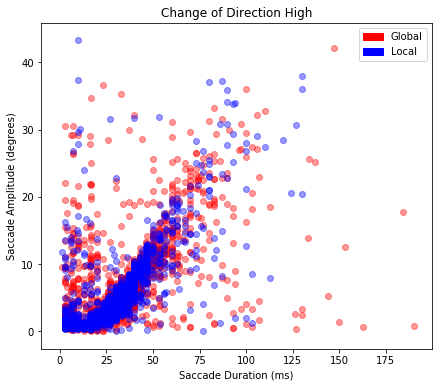

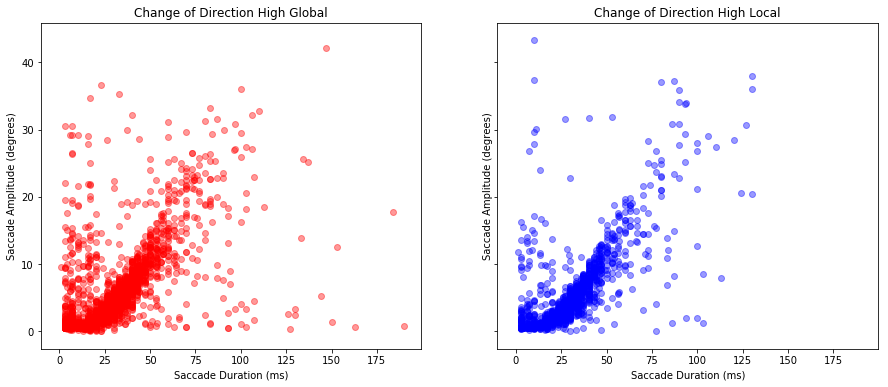

In [456]:
measure = "saccadeDur"
changeMeasure(measure)
x1 = messyDirectionGlobal
x1 = [item for sublist in x1 for item in sublist]
x2 = messyDirectionLocal
x2 = [item for sublist in x2 for item in sublist]
measure = "saccadeAmp"
changeMeasure(measure)
y1 = messyDirectionGlobal
y1 = [item for sublist in y1 for item in sublist]
y2 = messyDirectionLocal
y2 = [item for sublist in y2 for item in sublist]
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(x1, y1, color='r', alpha=.4)
ax.scatter(x2, y2, color='b', alpha=.4)
red_patch = mpatches.Patch(color='red', label='Global')
blue_patch = mpatches.Patch(color='blue', label='Local')
ax.legend(handles=[red_patch, blue_patch])
ax.set_title("Change of Direction High")
ax.set_ylabel("Saccade Amplitude (degrees)")
ax.set_xlabel("Saccade Duration (ms)")


f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,6))
ax1.scatter(x1, y1, color='r', alpha=.4)
ax1.set_title('Change of Direction High Global')
ax1.set_ylabel("Saccade Amplitude (degrees)")
ax1.set_xlabel("Saccade Duration (ms)")
ax2.scatter(x2, y2, color='b', alpha=.4)
ax2.set_title('Change of Direction High Local')
ax2.set_ylabel("Saccade Amplitude (degrees)")
ax2.set_xlabel("Saccade Duration (ms)")


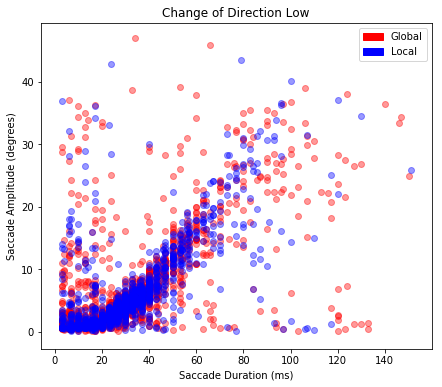

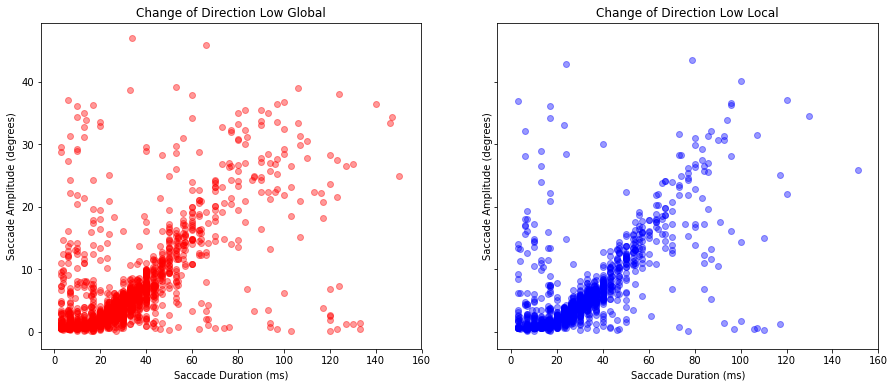

In [457]:
measure = "saccadeDur"
changeMeasure(measure)
x1 = nonMessyDirectionGlobal
x1 = [item for sublist in x1 for item in sublist]
x2 = nonMessyDirectionLocal
x2 = [item for sublist in x2 for item in sublist]
measure = "saccadeAmp"
changeMeasure(measure)
y1 = nonMessyDirectionGlobal
y1 = [item for sublist in y1 for item in sublist]
y2 = nonMessyDirectionLocal
y2 = [item for sublist in y2 for item in sublist]
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(x1, y1, color='r', alpha=.4)
ax.scatter(x2, y2, color='b', alpha=.4)
red_patch = mpatches.Patch(color='red', label='Global')
blue_patch = mpatches.Patch(color='blue', label='Local')
ax.legend(handles=[red_patch, blue_patch])
ax.set_title("Change of Direction Low")
ax.set_ylabel("Saccade Amplitude (degrees)")
ax.set_xlabel("Saccade Duration (ms)")


f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,6))
ax1.scatter(x1, y1, color='r', alpha=.4)
ax1.set_title('Change of Direction Low Global')
ax1.set_ylabel("Saccade Amplitude (degrees)")
ax1.set_xlabel("Saccade Duration (ms)")
ax2.scatter(x2, y2, color='b', alpha=.4)
ax2.set_title('Change of Direction Low Local')
ax2.set_ylabel("Saccade Amplitude (degrees)")
ax2.set_xlabel("Saccade Duration (ms)")

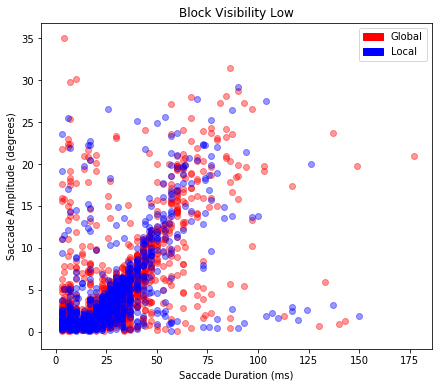

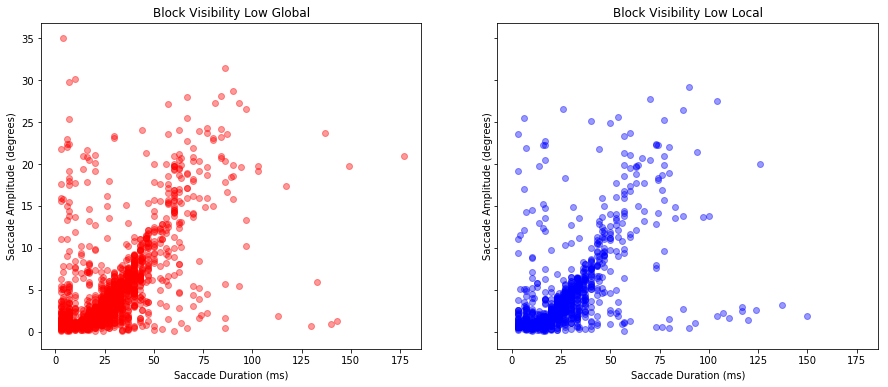

In [465]:
measure = "saccadeDur"
changeMeasure(measure)
x1 = messyVisibilityGlobal
x1 = [item for sublist in x1 for item in sublist]
x2 = messyVisibilityLocal
x2 = [item for sublist in x2 for item in sublist]
measure = "saccadeAmp"
changeMeasure(measure)
y1 = messyVisibilityGlobal
y1 = [item for sublist in y1 for item in sublist]
y2 = messyVisibilityLocal
y2 = [item for sublist in y2 for item in sublist]
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(x1, y1, color='r', alpha=.4)
ax.scatter(x2, y2, color='b', alpha=.4)
red_patch = mpatches.Patch(color='red', label='Global')
blue_patch = mpatches.Patch(color='blue', label='Local')
ax.legend(handles=[red_patch, blue_patch])
ax.set_title("Block Visibility Low")
ax.set_ylabel("Saccade Amplitude (degrees)")
ax.set_xlabel("Saccade Duration (ms)")
fig.savefig('BVLow.png', transparent=True)


f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,6))
ax1.scatter(x1, y1, color='r', alpha=.4)
ax1.set_title('Block Visibility Low Global')
ax1.set_ylabel("Saccade Amplitude (degrees)")
ax1.set_xlabel("Saccade Duration (ms)")
ax2.scatter(x2, y2, color='b', alpha=.4)
ax2.set_title('Block Visibility Low Local')
ax2.set_ylabel("Saccade Amplitude (degrees)")
ax2.set_xlabel("Saccade Duration (ms)")

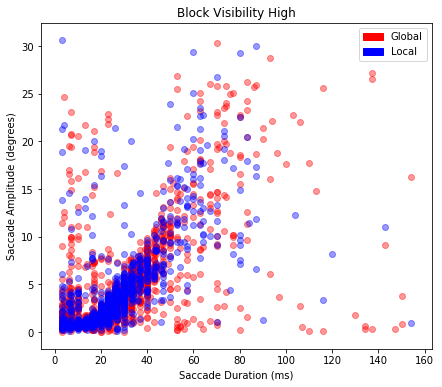

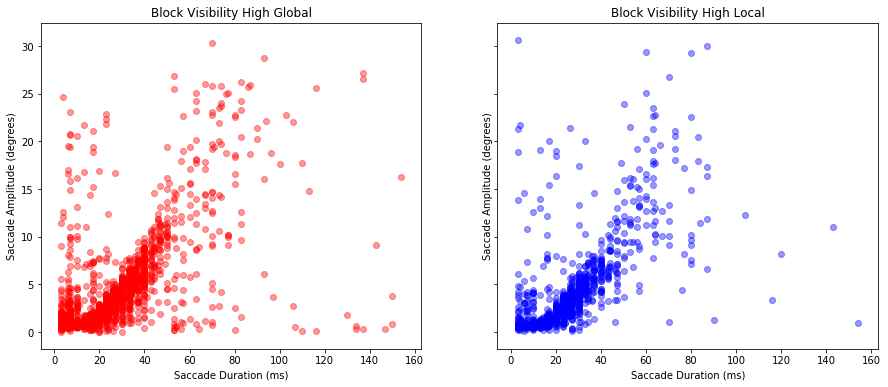

In [459]:
measure = "saccadeDur"
changeMeasure(measure)
x1 = nonMessyVisibilityGlobal
x1 = [item for sublist in x1 for item in sublist]
x2 = nonMessyVisibilityLocal
x2 = [item for sublist in x2 for item in sublist]
measure = "saccadeAmp"
changeMeasure(measure)
y1 = nonMessyVisibilityGlobal
y1 = [item for sublist in y1 for item in sublist]
y2 = nonMessyVisibilityLocal
y2 = [item for sublist in y2 for item in sublist]
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(x1, y1, color='r', alpha=.4)
ax.scatter(x2, y2, color='b', alpha=.4)
red_patch = mpatches.Patch(color='red', label='Global')
blue_patch = mpatches.Patch(color='blue', label='Local')
ax.legend(handles=[red_patch, blue_patch])
ax.set_title("Block Visibility High")
ax.set_ylabel("Saccade Amplitude (degrees)")
ax.set_xlabel("Saccade Duration (ms)")


f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,6))
ax1.scatter(x1, y1, color='r', alpha=.4)
ax1.set_title('Block Visibility High Global')
ax1.set_ylabel("Saccade Amplitude (degrees)")
ax1.set_xlabel("Saccade Duration (ms)")
ax2.scatter(x2, y2, color='b', alpha=.4)
ax2.set_title('Block Visibility High Local')
ax2.set_ylabel("Saccade Amplitude (degrees)")
ax2.set_xlabel("Saccade Duration (ms)")

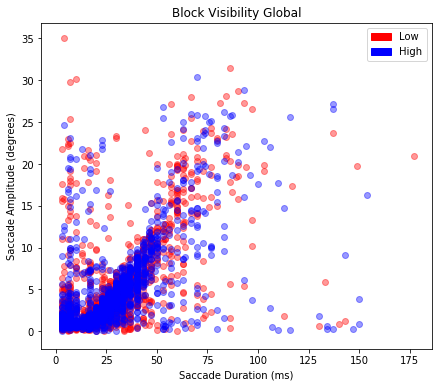

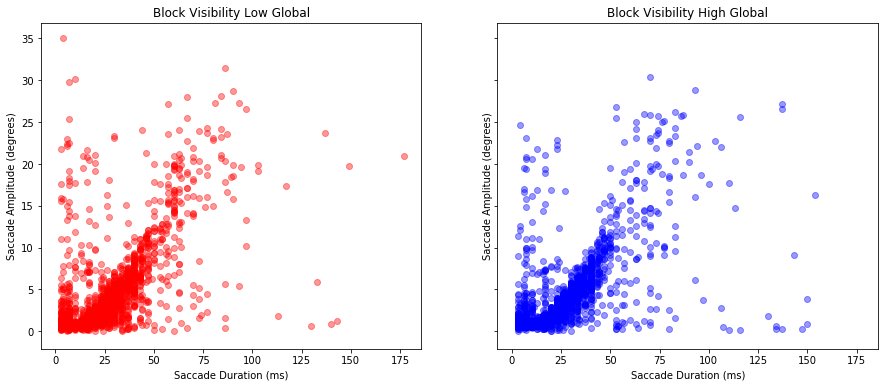

In [463]:
measure = "saccadeDur"
changeMeasure(measure)
x1 = messyVisibilityGlobal
x1 = [item for sublist in x1 for item in sublist]
x2 = nonMessyVisibilityGlobal
x2 = [item for sublist in x2 for item in sublist]
measure = "saccadeAmp"
changeMeasure(measure)
y1 = messyVisibilityGlobal
y1 = [item for sublist in y1 for item in sublist]
y2 = nonMessyVisibilityGlobal
y2 = [item for sublist in y2 for item in sublist]
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(x1, y1, color='r', alpha=.4)
ax.scatter(x2, y2, color='b', alpha=.4)
red_patch = mpatches.Patch(color='red', label='Low')
blue_patch = mpatches.Patch(color='blue', label='High')
ax.legend(handles=[red_patch, blue_patch])
ax.set_title("Block Visibility Global")
ax.set_ylabel("Saccade Amplitude (degrees)")
ax.set_xlabel("Saccade Duration (ms)")
fig.savefig('BVGlobal', transparent=True)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,6))
ax1.scatter(x1, y1, color='r', alpha=.4)
ax1.set_title('Block Visibility Low Global')
ax1.set_ylabel("Saccade Amplitude (degrees)")
ax1.set_xlabel("Saccade Duration (ms)")
ax2.scatter(x2, y2, color='b', alpha=.4)
ax2.set_title('Block Visibility High Global')
ax2.set_ylabel("Saccade Amplitude (degrees)")
ax2.set_xlabel("Saccade Duration (ms)")

In [461]:
measure = "amountOfFixations"
print "Model 1 A Local"
print "%0.2f" % (np.mean(data["M1A-Q01.png"][measure]),), "%0.2f" % (np.mean(data["M1A-Q02.png"][measure]),), "%0.2f" % ( np.mean(data["M1A-Q03.png"][measure]),) 
print "Model 1 A Global"
print "%0.2f" % (np.mean(data["M1A-Q04.png"][measure]),), "%0.2f" % (np.mean(data["M1A-Q05.png"][measure]),), "%0.2f" % ( np.mean(data["M1A-Q06.png"][measure]),)
print "Model 1 B Local"
print "%0.2f" % (np.mean(data["M1B-Q01.png"][measure]),), "%0.2f" % (np.mean(data["M1B-Q02.png"][measure]),), "%0.2f" % ( np.mean(data["M1B-Q03.png"][measure]),)
print "Model 1 B Global"
print "%0.2f" % (np.mean(data["M1B-Q04.png"][measure]),), "%0.2f" % (np.mean(data["M1B-Q05.png"][measure]),), "%0.2f" % ( np.mean(data["M1B-Q06.png"][measure]),)
print "Model 2 A Local"
print "%0.2f" % (np.mean(data["M2A-Q07.png"][measure]),), "%0.2f" % (np.mean(data["M2A-Q08.png"][measure]),), "%0.2f" % ( np.mean(data["M2A-Q09.png"][measure]),)
print "Model 2 A Global"
print "%0.2f" % (np.mean(data["M2A-Q10.png"][measure]),), "%0.2f" % (np.mean(data["M2A-Q11.png"][measure]),), "%0.2f" % ( np.mean(data["M2A-Q12.png"][measure]),)
print "Model 2 B Local"
print "%0.2f" % (np.mean(data["M2B-Q07.png"][measure]),), "%0.2f" % (np.mean(data["M2B-Q08.png"][measure]),), "%0.2f" % ( np.mean(data["M2B-Q09.png"][measure]),)
print "Model 2 B Global"
print "%0.2f" % (np.mean(data["M2B-Q10.png"][measure]),), "%0.2f" % (np.mean(data["M2B-Q11.png"][measure]),), "%0.2f" % ( np.mean(data["M2B-Q12.png"][measure]),)
print "Model 3 A Local"
print "%0.2f" % (np.mean(data["M3A-Q13.png"][measure]),), "%0.2f" % (np.mean(data["M3A-Q14.png"][measure]),), "%0.2f" % ( np.mean(data["M3A-Q15.png"][measure] ),)
print "Model 3 A Global"
print "%0.2f" % (np.mean(data["M3A-Q16.png"][measure]),), "%0.2f" % (np.mean(data["M3A-Q17.png"][measure]),), "%0.2f" % ( np.mean(data["M3A-Q18.png"][measure]),)
print "Model 3 B Local"
print "%0.2f" % (np.mean(data["M3B-Q13.png"][measure]),), "%0.2f" % (np.mean(data["M3B-Q14.png"][measure]),), "%0.2f" % ( np.mean(data["M3B-Q15.png"][measure] ),)
print "Model 3 B Global"
print "%0.2f" % (np.mean(data["M3B-Q16.png"][measure]),), "%0.2f" % (np.mean(data["M3B-Q17.png"][measure]),), "%0.2f" % ( np.mean(data["M3B-Q18.png"][measure]),)
print "Model 4 A Local"
print "%0.2f" % (np.mean(data["M4A-Q19.png"][measure]),), "%0.2f" % (np.mean(data["M4A-Q20.png"][measure]),), "%0.2f" % ( np.mean(data["M4A-Q24.png"][measure] ),)
print "Model 4 A Global"
print "%0.2f" % (np.mean(data["M4A-Q22.png"][measure]),), "%0.2f" % (np.mean(data["M4A-Q23.png"][measure]),), "%0.2f" % ( np.mean(data["M4A-Q21.png"][measure]),)
print "Model 4 B Local"
print "%0.2f" % (np.mean(data["M4B-Q19.png"][measure]),), "%0.2f" % (np.mean(data["M4B-Q20.png"][measure]),), "%0.2f" % ( np.mean(data["M4B-Q24.png"][measure] ),)
print "Model 4 B Global"
print "%0.2f" % (np.mean(data["M4B-Q22.png"][measure]),), "%0.2f" % (np.mean(data["M4B-Q23.png"][measure]),), "%0.2f" % ( np.mean(data["M4B-Q21.png"][measure]),)

Model 1 A Local
54.14 77.00 63.43
Model 1 A Global
105.14 69.57 85.00
Model 1 B Local
75.00 58.00 79.67
Model 1 B Global
87.17 65.00 73.00
Model 2 A Local
64.71 54.57 54.00
Model 2 A Global
94.86 77.00 106.14
Model 2 B Local
35.50 32.17 22.33
Model 2 B Global
53.50 36.33 46.00
Model 3 A Local
53.57 38.86 31.29
Model 3 A Global
112.86 91.29 96.29
Model 3 B Local
42.67 33.50 19.67
Model 3 B Global
54.00 53.00 63.33
Model 4 A Local
41.43 36.29 52.29
Model 4 A Global
91.29 99.00 82.57
Model 4 B Local
48.00 30.50 49.33
Model 4 B Global
64.17 58.17 77.50


In [462]:
measure = "amountOfFixations"
print "Model 1 A Local","%0.2f" % (np.mean(data["M1A-Q01.png"][measure]),), "%0.2f" % (np.mean(data["M1A-Q02.png"][measure]),), "%0.2f" % ( np.mean(data["M1A-Q03.png"][measure]),) ,"Model 1 A Global","%0.2f" % (np.mean(data["M1A-Q04.png"][measure]),), "%0.2f" % (np.mean(data["M1A-Q05.png"][measure]),), "%0.2f" % ( np.mean(data["M1A-Q06.png"][measure]),)
print "Model 1 B Local","%0.2f" % (np.mean(data["M1B-Q01.png"][measure]),), "%0.2f" % (np.mean(data["M1B-Q02.png"][measure]),), "%0.2f" % ( np.mean(data["M1B-Q03.png"][measure]),),"Model 1 B Global","%0.2f" % (np.mean(data["M1B-Q04.png"][measure]),), "%0.2f" % (np.mean(data["M1B-Q05.png"][measure]),), "%0.2f" % ( np.mean(data["M1B-Q06.png"][measure]),)
print "Model 2 A Local","%0.2f" % (np.mean(data["M2A-Q07.png"][measure]),), "%0.2f" % (np.mean(data["M2A-Q08.png"][measure]),), "%0.2f" % ( np.mean(data["M2A-Q09.png"][measure]),),"Model 2 A Global","%0.2f" % (np.mean(data["M2A-Q10.png"][measure]),), "%0.2f" % (np.mean(data["M2A-Q11.png"][measure]),), "%0.2f" % ( np.mean(data["M2A-Q12.png"][measure]),)
print "Model 2 B Local","%0.2f" % (np.mean(data["M2B-Q07.png"][measure]),), "%0.2f" % (np.mean(data["M2B-Q08.png"][measure]),), "%0.2f" % ( np.mean(data["M2B-Q09.png"][measure]),),"Model 2 B Global","%0.2f" % (np.mean(data["M2B-Q10.png"][measure]),), "%0.2f" % (np.mean(data["M2B-Q11.png"][measure]),), "%0.2f" % ( np.mean(data["M2B-Q12.png"][measure]),)
print "Model 3 A Local","%0.2f" % (np.mean(data["M3A-Q13.png"][measure]),), "%0.2f" % (np.mean(data["M3A-Q14.png"][measure]),), "%0.2f" % ( np.mean(data["M3A-Q15.png"][measure] ),),"Model 3 A Global","%0.2f" % (np.mean(data["M3A-Q16.png"][measure]),), "%0.2f" % (np.mean(data["M3A-Q17.png"][measure]),), "%0.2f" % ( np.mean(data["M3A-Q18.png"][measure]),)
print "Model 3 B Local","%0.2f" % (np.mean(data["M3B-Q13.png"][measure]),), "%0.2f" % (np.mean(data["M3B-Q14.png"][measure]),), "%0.2f" % ( np.mean(data["M3B-Q15.png"][measure] ),),"Model 3 B Global","%0.2f" % (np.mean(data["M3B-Q16.png"][measure]),), "%0.2f" % (np.mean(data["M3B-Q17.png"][measure]),), "%0.2f" % ( np.mean(data["M3B-Q18.png"][measure]),)
print "Model 4 A Local","%0.2f" % (np.mean(data["M4A-Q19.png"][measure]),), "%0.2f" % (np.mean(data["M4A-Q20.png"][measure]),), "%0.2f" % ( np.mean(data["M4A-Q24.png"][measure] ),),"Model 4 A Global","%0.2f" % (np.mean(data["M4A-Q22.png"][measure]),), "%0.2f" % (np.mean(data["M4A-Q23.png"][measure]),), "%0.2f" % ( np.mean(data["M4A-Q21.png"][measure]),)
print "Model 4 B Local","%0.2f" % (np.mean(data["M4B-Q19.png"][measure]),), "%0.2f" % (np.mean(data["M4B-Q20.png"][measure]),), "%0.2f" % ( np.mean(data["M4B-Q24.png"][measure] ),),"Model 4 B Global","%0.2f" % (np.mean(data["M4B-Q22.png"][measure]),), "%0.2f" % (np.mean(data["M4B-Q23.png"][measure]),), "%0.2f" % ( np.mean(data["M4B-Q21.png"][measure]),)

Model 1 A Local 54.14 77.00 63.43 Model 1 A Global 105.14 69.57 85.00
Model 1 B Local 75.00 58.00 79.67 Model 1 B Global 87.17 65.00 73.00
Model 2 A Local 64.71 54.57 54.00 Model 2 A Global 94.86 77.00 106.14
Model 2 B Local 35.50 32.17 22.33 Model 2 B Global 53.50 36.33 46.00
Model 3 A Local 53.57 38.86 31.29 Model 3 A Global 112.86 91.29 96.29
Model 3 B Local 42.67 33.50 19.67 Model 3 B Global 54.00 53.00 63.33
Model 4 A Local 41.43 36.29 52.29 Model 4 A Global 91.29 99.00 82.57
Model 4 B Local 48.00 30.50 49.33 Model 4 B Global 64.17 58.17 77.50


In [38]:
measure = "fixationDurationTotal"
print "Model 1 A Local","%0.2f" % (np.mean(data["M1A-Q01.png"][measure]),), "%0.2f" % (np.mean(data["M1A-Q02.png"][measure]),), "%0.2f" % ( np.mean(data["M1A-Q03.png"][measure]),) ,"Model 1 A Global","%0.2f" % (np.mean(data["M1A-Q04.png"][measure]),), "%0.2f" % (np.mean(data["M1A-Q05.png"][measure]),), "%0.2f" % ( np.mean(data["M1A-Q06.png"][measure]),)
print "Model 1 B Local","%0.2f" % (np.mean(data["M1B-Q01.png"][measure]),), "%0.2f" % (np.mean(data["M1B-Q02.png"][measure]),), "%0.2f" % ( np.mean(data["M1B-Q03.png"][measure]),),"Model 1 B Global","%0.2f" % (np.mean(data["M1B-Q04.png"][measure]),), "%0.2f" % (np.mean(data["M1B-Q05.png"][measure]),), "%0.2f" % ( np.mean(data["M1B-Q06.png"][measure]),)
print "Model 2 A Local","%0.2f" % (np.mean(data["M2A-Q07.png"][measure]),), "%0.2f" % (np.mean(data["M2A-Q08.png"][measure]),), "%0.2f" % ( np.mean(data["M2A-Q09.png"][measure]),),"Model 2 A Global","%0.2f" % (np.mean(data["M2A-Q10.png"][measure]),), "%0.2f" % (np.mean(data["M2A-Q11.png"][measure]),), "%0.2f" % ( np.mean(data["M2A-Q12.png"][measure]),)
print "Model 2 B Local","%0.2f" % (np.mean(data["M2B-Q07.png"][measure]),), "%0.2f" % (np.mean(data["M2B-Q08.png"][measure]),), "%0.2f" % ( np.mean(data["M2B-Q09.png"][measure]),),"Model 2 B Global","%0.2f" % (np.mean(data["M2B-Q10.png"][measure]),), "%0.2f" % (np.mean(data["M2B-Q11.png"][measure]),), "%0.2f" % ( np.mean(data["M2B-Q12.png"][measure]),)
print "Model 3 A Local","%0.2f" % (np.mean(data["M3A-Q13.png"][measure]),), "%0.2f" % (np.mean(data["M3A-Q14.png"][measure]),), "%0.2f" % ( np.mean(data["M3A-Q15.png"][measure] ),),"Model 3 A Global","%0.2f" % (np.mean(data["M3A-Q16.png"][measure]),), "%0.2f" % (np.mean(data["M3A-Q17.png"][measure]),), "%0.2f" % ( np.mean(data["M3A-Q18.png"][measure]),)
print "Model 3 B Local","%0.2f" % (np.mean(data["M3B-Q13.png"][measure]),), "%0.2f" % (np.mean(data["M3B-Q14.png"][measure]),), "%0.2f" % ( np.mean(data["M3B-Q15.png"][measure] ),),"Model 3 B Global","%0.2f" % (np.mean(data["M3B-Q16.png"][measure]),), "%0.2f" % (np.mean(data["M3B-Q17.png"][measure]),), "%0.2f" % ( np.mean(data["M3B-Q18.png"][measure]),)
print "Model 4 A Local","%0.2f" % (np.mean(data["M4A-Q19.png"][measure]),), "%0.2f" % (np.mean(data["M4A-Q20.png"][measure]),), "%0.2f" % ( np.mean(data["M4A-Q24.png"][measure] ),),"Model 4 A Global","%0.2f" % (np.mean(data["M4A-Q22.png"][measure]),), "%0.2f" % (np.mean(data["M4A-Q23.png"][measure]),), "%0.2f" % ( np.mean(data["M4A-Q21.png"][measure]),)
print "Model 4 B Local","%0.2f" % (np.mean(data["M4B-Q19.png"][measure]),), "%0.2f" % (np.mean(data["M4B-Q20.png"][measure]),), "%0.2f" % ( np.mean(data["M4B-Q24.png"][measure] ),),"Model 4 B Global","%0.2f" % (np.mean(data["M4B-Q22.png"][measure]),), "%0.2f" % (np.mean(data["M4B-Q23.png"][measure]),), "%0.2f" % ( np.mean(data["M4B-Q21.png"][measure]),)

Model 1 A Local 13001.00 19562.29 14272.71 Model 1 A Global 24541.57 15646.43 20171.43
Model 1 B Local 18594.83 14263.83 18230.83 Model 1 B Global 19303.67 14518.00 16961.83
Model 2 A Local 19894.57 13824.86 13202.71 Model 2 A Global 24509.29 20404.86 28134.71
Model 2 B Local 8056.50 7162.00 5043.67 Model 2 B Global 11450.00 8279.00 9188.00
Model 3 A Local 13109.57 9680.71 7674.71 Model 3 A Global 28416.71 21786.43 22265.43
Model 3 B Local 8810.67 6933.00 3995.33 Model 3 B Global 12070.67 11431.17 12538.00
Model 4 A Local 11697.00 8973.57 12624.29 Model 4 A Global 23581.43 25803.00 22367.00
Model 4 B Local 11692.17 7920.83 11034.67 Model 4 B Global 14929.83 14864.00 17686.33


In [74]:
measure = "saccadeVel"
print "Model 1 A Local","%0.4f" % (np.mean(data["M1A-Q01.png"][measure]),), "%0.4f" % (np.mean(data["M1A-Q02.png"][measure]),), "%0.4f" % ( np.mean(data["M1A-Q03.png"][measure]),),"Model 1 A Global","%0.4f" % (np.mean(data["M1A-Q04.png"][measure]),), "%0.4f" % (np.mean(data["M1A-Q05.png"][measure]),), "%0.4f" % ( np.mean(data["M1A-Q06.png"][measure]),)
print "Model 1 B Local","%0.4f" % (np.mean(data["M1B-Q01.png"][measure]),), "%0.4f" % (np.mean(data["M1B-Q02.png"][measure]),), "%0.4f" % ( np.mean(data["M1B-Q03.png"][measure]),),"Model 1 B Global","%0.4f" % (np.mean(data["M1B-Q04.png"][measure]),), "%0.4f" % (np.mean(data["M1B-Q05.png"][measure]),), "%0.4f" % ( np.mean(data["M1B-Q06.png"][measure]),)
print "Model 2 A Local","%0.4f" % (np.mean(data["M2A-Q07.png"][measure]),), "%0.4f" % (np.mean(data["M2A-Q08.png"][measure]),), "%0.4f" % ( np.mean(data["M2A-Q09.png"][measure]),),"Model 2 A Global","%0.4f" % (np.mean(data["M2A-Q10.png"][measure]),), "%0.4f" % (np.mean(data["M2A-Q11.png"][measure]),), "%0.4f" % ( np.mean(data["M2A-Q12.png"][measure]),)
print "Model 2 B Local","%0.4f" % (np.mean(data["M2B-Q07.png"][measure]),), "%0.4f" % (np.mean(data["M2B-Q08.png"][measure]),), "%0.4f" % ( np.mean(data["M2B-Q09.png"][measure]),),"Model 2 B Global","%0.4f" % (np.mean(data["M2B-Q10.png"][measure]),), "%0.4f" % (np.mean(data["M2B-Q11.png"][measure]),), "%0.4f" % ( np.mean(data["M2B-Q12.png"][measure]),)
print "Model 3 A Local","%0.4f" % (np.mean(data["M3A-Q13.png"][measure]),), "%0.4f" % (np.mean(data["M3A-Q14.png"][measure]),), "%0.4f" % ( np.mean(data["M3A-Q15.png"][measure]),),"Model 3 A Global","%0.4f" % (np.mean(data["M3A-Q16.png"][measure]),), "%0.4f" % (np.mean(data["M3A-Q17.png"][measure]),), "%0.4f" % ( np.mean(data["M3A-Q18.png"][measure]),)
print "Model 3 B Local","%0.4f" % (np.mean(data["M3B-Q13.png"][measure]),), "%0.4f" % (np.mean(data["M3B-Q14.png"][measure]),), "%0.4f" % ( np.mean(data["M3B-Q15.png"][measure]),),"Model 3 B Global","%0.4f" % (np.mean(data["M3B-Q16.png"][measure]),), "%0.4f" % (np.mean(data["M3B-Q17.png"][measure]),), "%0.4f" % ( np.mean(data["M3B-Q18.png"][measure]),)
print "Model 4 A Local","%0.4f" % (np.mean(data["M4A-Q19.png"][measure]),), "%0.4f" % (np.mean(data["M4A-Q20.png"][measure]),), "%0.4f" % ( np.mean(data["M4A-Q24.png"][measure]),),"Model 4 A Global","%0.4f" % (np.mean(data["M4A-Q22.png"][measure]),), "%0.4f" % (np.mean(data["M4A-Q23.png"][measure]),), "%0.4f" % ( np.mean(data["M4A-Q21.png"][measure]),)
print "Model 4 B Local","%0.4f" % (np.mean(data["M4B-Q19.png"][measure]),), "%0.4f" % (np.mean(data["M4B-Q20.png"][measure]),), "%0.4f" % ( np.mean(data["M4B-Q24.png"][measure]),),"Model 4 B Global","%0.4f" % (np.mean(data["M4B-Q22.png"][measure]),), "%0.4f" % (np.mean(data["M4B-Q23.png"][measure]),), "%0.4f" % ( np.mean(data["M4B-Q21.png"][measure]),)

Model 1 A Local 0.1855 0.2176 0.2083 Model 1 A Global 0.2023 0.2272 0.2133
Model 1 B Local 0.1972 0.1911 0.2273 Model 1 B Global 0.2164 0.2789 0.1889
Model 2 A Local 0.1285 0.1515 0.1596 Model 2 A Global 0.1882 0.1448 0.1842
Model 2 B Local 0.1718 0.1592 0.1314 Model 2 B Global 0.1825 0.1543 0.2392
Model 3 A Local 0.1505 0.1794 0.1601 Model 3 A Global 0.1888 0.1749 0.1663
Model 3 B Local 0.1733 0.1936 0.1319 Model 3 B Global 0.1497 0.1783 0.1918
Model 4 A Local 0.1253 0.1950 0.1908 Model 4 A Global 0.1764 0.1440 0.1517
Model 4 B Local 0.1465 0.1403 0.1509 Model 4 B Global 0.1954 0.1590 0.1384


In [71]:
data["M1A-Q01.png"]["saccadeVel"] = sum(data["M1A-Q01.png"]["saccadeVel"], [])
np.mean(data["M1A-Q01.png"]["saccadeVel"])

0.18669972728308606

In [448]:
print np.mean(data["M1A-Q01.png"]["amountOfFixations"])
print np.mean(sorted(data["M1B-Q01.png"]["amountOfFixations"])[:-1])

54.1428571429
56.2


In [452]:
print np.mean(sorted(data["M1A-Q02.png"]["amountOfFixations"])[:-1])
print np.mean(sorted(data["M1B-Q02.png"]["amountOfFixations"]))

58.1666666667
58.0


In [449]:
print np.mean(data["M1A-Q03.png"]["amountOfFixations"])
print np.mean(sorted(data["M1B-Q03.png"]["amountOfFixations"])[:-1])

63.4285714286
66.2


In [446]:
print sorted(data["M1A-Q01.png"]["amountOfFixations"])
print sorted(data["M1B-Q01.png"]["amountOfFixations"])

[31, 35, 36, 55, 57, 70, 95]
[31, 36, 54, 78, 82, 169]


In [445]:
print sorted(data["M1A-Q02.png"]["amountOfFixations"])
print sorted(data["M1B-Q02.png"]["amountOfFixations"])

[37, 39, 52, 61, 71, 89, 190]
[43, 45, 52, 56, 57, 95]


In [453]:
print sorted(data["M1A-Q02.png"]["fixationDurationTotal"])
print sorted(data["M1B-Q02.png"]["fixationDurationTotal"])

[10090, 11791, 12199, 14685, 17274, 21753, 49144]
[8291, 11226, 13689, 14560, 14631, 23186]


In [447]:
print sorted(data["M1A-Q03.png"]["amountOfFixations"])
print sorted(data["M1B-Q03.png"]["amountOfFixations"])

[33, 40, 43, 56, 81, 86, 105]
[55, 64, 67, 67, 78, 147]
